In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.transforms import Bbox
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

from copy import deepcopy

import skfda
from skfda import FDataGrid
from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.representation.basis import BSpline, Fourier, Monomial

import divebomb

import time
import pickle

import importlib

matplotlib.rcParams.update({'font.size': 12})
#matplotlib.rcParams.update({'lines.markersize': 20})

np.random.seed(0)
np.set_printoptions(suppress=True,precision=4)

In [2]:
import Preprocessor
import Parameters
import HHMM
import Visualisor

# Define Parameters

In [3]:
train_new = False # whether to train a new model locally
iterate_models = False # whether to go through all compute canada models
find_SEs = False # refind SEs after switching states
n_points = -1 # likelihood plot resolution (-1 will throw error and stop notebook)

#model = 'CarHMM'
#model = 'HHMM'
#model = 'CarHHMM1'
model = 'CarHHMM2'

whale = '20190902-182840-CATs_OB_1'
#whale = '20200822-170001-Gikumi_CC_130'
#whale = '20200830-180909-Gikumi_CC_136'

year = whale[:4]

date = '06-14-2021'

s_dive = 0

if whale == '20190902-182840-CATs_OB_1':
    
    e_dive = 267
    stime = '2019-09-02 13:20:00'
    etime = '2019-09-02 18:00:00'
    drop_times = [[1.6,1.8],[3.3,4.3]]
    
elif whale == '20200822-170001-Gikumi_CC_130':
    
    e_dive = 10 #832
    stime = '2020-08-22 08:15:00'
    etime = '2020-08-22 15:45:00'
    drop_times = []
    
elif whale == '20200830-180909-Gikumi_CC_136':
    
    e_dive = 426
    stime = '2020-08-30 10:50:00'
    etime = '2020-08-30 16:00:00'
    drop_times = []
    HHMM_file = '../Params/CarHHMM2_k_3_3_0'
    
else:
    e_dive = 10

share_fine_states = True

HHMM_file = '../../Params/real/%s/%s/%s_%s_%s_%s' % (year,whale,whale,s_dive,e_dive,model)

In [4]:
pars = Parameters.Parameters()

pars.cvc_file = '../Data/%s/%s/%s.cvc' % (year,whale,whale)
pars.csv_file = '../Data/%s/%s/%s.csv' % (year,whale,whale)

# only include for 2020 whale
pars.stime = stime
pars.etime = etime
pars.drop_times = drop_times

pars.share_fine_states = share_fine_states

pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'Ax':{'corr':True,'f':'normal'},
                  'Ay':{'corr':True,'f':'normal'},
                  'Az':{'corr':True,'f':'normal'},
                  'Ahat_low':{'thresh':5,'corr':False,'f':'gamma'}}]

pars.K = [2,3]
if model == 'CarHMM':
    pars.K = [1,3]
elif model == 'HHMM':
    pars.features[1]['Ax']['corr'] = False
    pars.features[1]['Ay']['corr'] = False
    pars.features[1]['Az']['corr'] = False
elif model == 'CarHHMM1':
    pars.features[1] = {'Ax':{'corr':True,'f':'normal'},
                        'Ay':{'corr':True,'f':'normal'},
                        'Az':{'corr':True,'f':'normal'}}

prep = Preprocessor.Preprocessor(pars)

# Preprocess Data

In [5]:
df = prep.load_data(pars.cvc_file,
                    pars.csv_file,
                    pars.cvc_cols)

In [6]:
df = prep.prune_cols(df)

df = prep.prune_times(df,
                      pars.stime,
                      pars.etime,
                      pars.drop_times)

df = prep.fix_pressure(df)

df = prep.find_Vz(df)

df = prep.smooth_columns(df,
                         pars.smoother,
                         pars.smooth_cols)

df,dive_df = prep.find_dives(df)

data = prep.get_all_features(df,dive_df)

viz = Visualisor.Visualisor(pars,data,df)

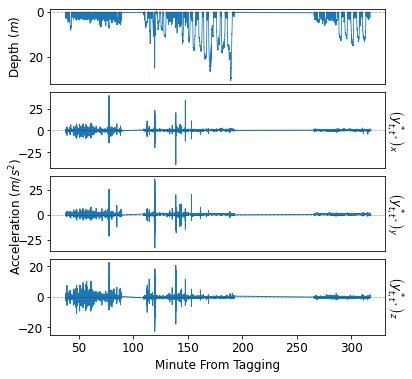

In [7]:
sdive = 0
edive = e_dive

fig,ax = plt.subplots(4,1,figsize = (6,6))

ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df[(df['dive_num'] >= sdive) & (df['dive_num'] <= edive)]

plt.subplot(4,1,1)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=0.8)
#plt.ylim([30,-1])
plt.gca().invert_yaxis()
plt.xticks([])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.ylabel('Depth $(m)$',fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_x$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ax'],linewidth=1)
plt.xticks([])
#plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
#plt.yticks([-1,0,1],fontsize=12)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_y$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ay'],linewidth=1)
plt.xticks([])
#plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
#plt.yticks([-1,0,1],fontsize=12)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_z$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Az'],linewidth=1)
plt.xlabel('Minute From Tagging',fontsize=12)
#plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
#plt.yticks([-1,0,1],fontsize=12)
plt.xticks(fontsize=12)

fig.text(0.025, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=12)
plt.subplots_adjust(wspace=0, hspace=0.1)



plt.savefig('../Plots/%s/%s_%s_%s_%s_raw_data_5_dives' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

del temp_df

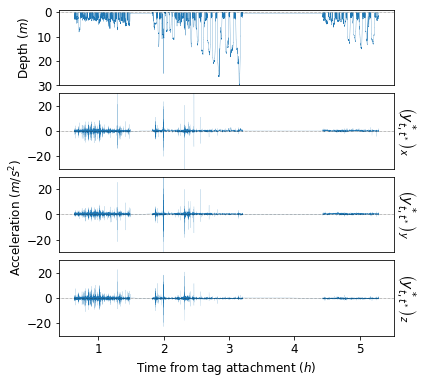

In [8]:
fig,ax = plt.subplots(4,1,figsize = (6,6),sharex=True)
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df

plt.subplot(4,1,1)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=0.25)
#plt.show()
#plt.title('Dive Profile / Accelerometer Data',fontsize=12)
plt.ylim([30,-1])
plt.xticks([])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.ylabel('Depth $(m)$',fontsize=12)
plt.yticks([0,10,20,30],fontsize=12)
#plt.show()

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_x$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Ax'],linewidth=0.1)
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_y$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Ay'],linewidth=0.1)
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_z$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Az'],linewidth=0.1)
plt.xlabel('Time from tag attachment $(h)$',fontsize=12)
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)
#plt.xticks([0,100,200,300],fontsize=12)

fig.text(0.005, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=12)

del temp_df
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig('../Plots/%s/%s_%s_%s_%s_raw_data' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

dive_duration
[[ 1.     -0.1272]
 [-0.1272  1.    ]]
Ax
[[1.     0.8574]
 [0.8574 1.    ]]
Ay
[[1.     0.6005]
 [0.6005 1.    ]]
Az
[[1.     0.7048]
 [0.7048 1.    ]]
Ahat_low
[[1.     0.8271]
 [0.8271 1.    ]]


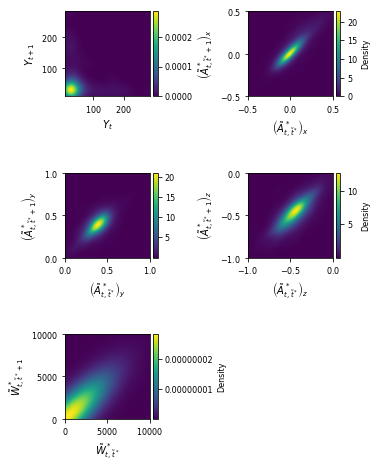

In [9]:
importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.lagplot(lims={'peak_jerk':[0,50],
                  'roll_at_pj':[0,1],
                  'heading_var':[0,0.2],
                  'Ahat_low':[0,10000],
                  'FoVeDBA_high':[0,10],
                  'Vz':[-5,5],
                  'Ax':[-0.5,0.5],
                  'Ay':[0,1.0],
                  'Az':[-1.0,0.0]},
           file = '../Plots/%s/%s_%s_%s_%s_lagplot.png' % (year,whale,s_dive,e_dive,model))

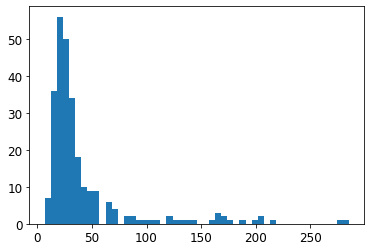

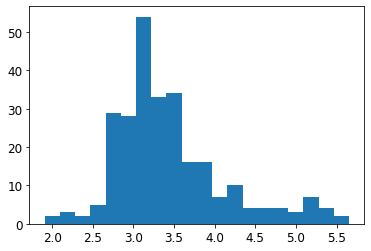

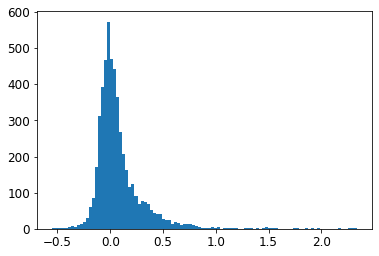

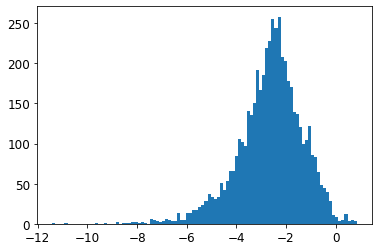

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning:

Pass n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



[[6.212 ]
 [3.5617]]
[[[1.9945]]

 [[0.7559]]]
[0.5036 0.4964]


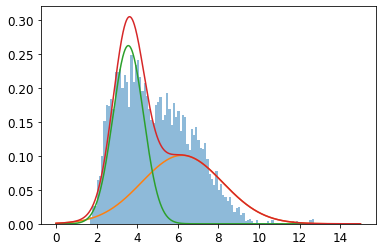

In [10]:
# plot dive duration
plt.hist([datum['dive_duration'] for datum in data],bins=50)
plt.show()

plt.hist([np.log(datum['dive_duration']) for datum in data],bins=20)
plt.show()

# get and plot acceleration
acc = []
for datum in data:
    for seg in datum['subdive_features']:
        acc.append(seg['Ax'])
        
plt.hist(acc,bins=100)
plt.show()

plt.hist([np.log(np.abs(x)) for x in acc],bins=100)
plt.show()
    
# get and plot ahat
if model != 'CarHHMM1':
    ahat = []
    for datum in data:
        for seg in datum['subdive_features']:
            ahat.append(np.log(seg['Ahat_low']))
    plt.hist(ahat,bins=100,alpha = 0.5,density=True)
    n=2
    from sklearn.mixture import BayesianGaussianMixture
    from sklearn.mixture import GaussianMixture
    GM = BayesianGaussianMixture(n,max_iter=10,n_init=10)
    GM.fit(np.array(ahat).reshape(-1, 1))
    print(GM.means_)
    print(GM.covariances_)
    print(GM.weights_)
    x = np.linspace(0,15,1000)
    total = np.zeros_like(x)
    for i in range(n):
        plt.plot(x,norm.pdf(x,loc=GM.means_[i][0],scale=GM.covariances_[i,0,0])*GM.weights_[i]/np.sum(GM.weights_))
        total += norm.pdf(x,loc=GM.means_[i][0],scale=GM.covariances_[i,0,0])*GM.weights_[i]
    plt.plot(x,total/np.sum(GM.weights_))
    plt.show()

# Explore FPCs

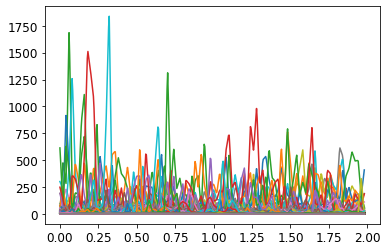

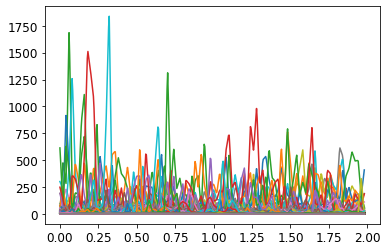

In [11]:
grid_points = np.linspace(0,1.98,100)
data_matrix = []
for dive in data:
    for seg in dive['subdive_features']:
        data_matrix.append(seg['Az_all']**2 + seg['Ay_all']**2 + seg['Ax_all']**2)
        
Ax_funcs = FDataGrid(data_matrix, grid_points)
Ax_funcs.plot()

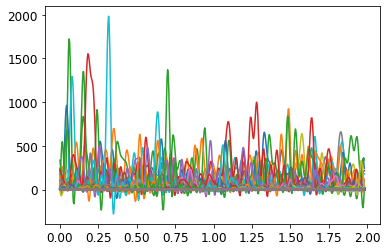

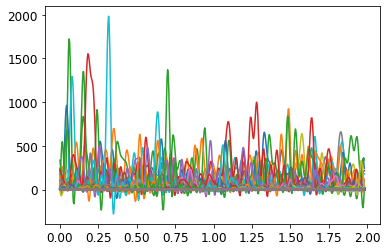

In [12]:
Ax_funcs_fourier = Ax_funcs.to_basis(skfda.representation.basis.Fourier(n_basis=99))
Ax_funcs_fourier.plot()

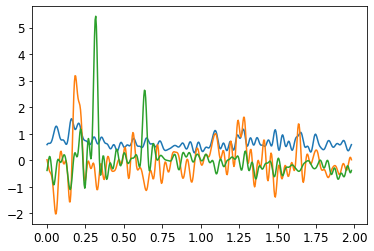

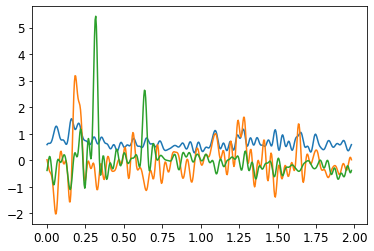

In [13]:
fpca = FPCA(n_components = 3)
fourier_coefs = fpca.fit_transform(Ax_funcs_fourier)
fpca.components_.plot()

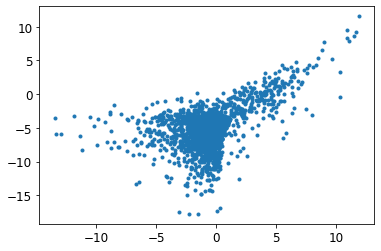

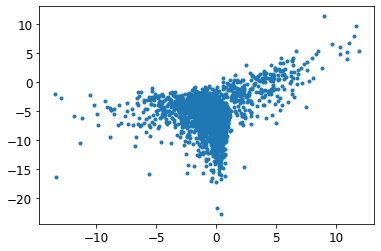

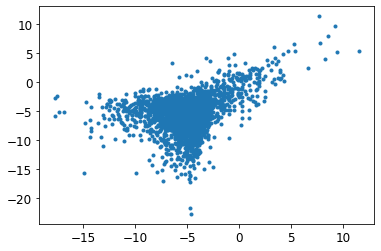

In [14]:
plt.plot(np.log(fourier_coefs[:,0]**2),np.log(fourier_coefs[:,1]**2),'.')
plt.show()
plt.plot(np.log(fourier_coefs[:,0]**2),np.log(fourier_coefs[:,2]**2),'.')
plt.show()
plt.plot(np.log(fourier_coefs[:,1]**2),np.log(fourier_coefs[:,2]**2),'.')

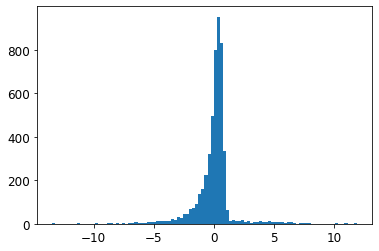

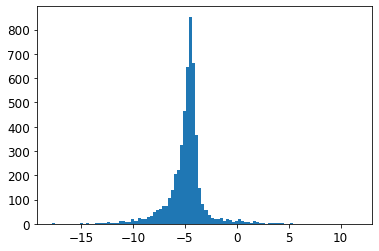

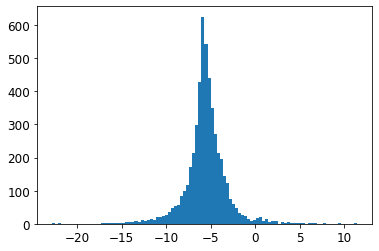

In [15]:
for i in range(3):
    plt.hist(np.log(fourier_coefs[:,i]**2),bins=100)
    plt.show()

# Train HHMM

In [16]:
deep_data = [data[i] for i in range(s_dive,e_dive)]
importlib.reload(HHMM)
hhmm = HHMM.HHMM(pars,deep_data)

try:
    hhmm = hhmm.load(HHMM_file)
except:
    if model == 'CarHMM':
        i = 1
    elif model == 'HHMM':
        i = 101
    elif model == 'CarHHMM1':
        i = 201
    elif model == 'CarHHMM2':
        i = 301
    else:
        print('model %s not recognized' % model)

    if model == 'CarHMM':
        HHMM_file_i = '../../Params/real/%s/%s/%s/%s_k_1_3_%s' % (year,whale,date,model,i)
    else:
        HHMM_file_i = '../../Params/real/%s/%s/%s/%s_k_2_3_%s' % (year,whale,date,model,i)
    print('file %s not found. Loading file %s' % (HHMM_file,HHMM_file_i))
    hhmm = hhmm.load(HHMM_file_i)
print(hhmm.likelihood(deep_data))

-20250.575938838094


In [17]:
if iterate_models:
    best_hhmm = hhmm
    l = hhmm.likelihood(deep_data)
    print('original likelihood:')
    print(l)
    print('')
    max_likelihood = l

    if model == 'CarHMM':
        rng = range(1,101)
    elif model == 'HHMM':
        rng = range(101,201)
    elif model == 'CarHHMM1':
        rng = range(201,301)
    elif model == 'CarHHMM2':
        rng = range(301,401)
    else:
        print('model %s not recognized' % model)

    for i in rng:

        if model == 'CarHMM':
            HHMM_file_i = '../../Params/real/%s/%s/%s/%s_k_1_3_%s' % (year,whale,date,model,i)
        else:
            HHMM_file_i = '../../Params/real/%s/%s/%s/%s_k_2_3_%s' % (year,whale,date,model,i)

        # load model
        try:
            hhmm = hhmm.load(HHMM_file_i)
        except:
            print('No existing HMM model number %d' % i)
            continue

        l = hhmm.likelihood(deep_data)
        print(l)
        if l > max_likelihood or np.isnan(max_likelihood):
            max_likelihood = l
            best_hhmm = hhmm
            print('new best model')

    hhmm = best_hhmm

In [18]:
theta0 = deepcopy(hhmm.theta)
eta0 = deepcopy(hhmm.eta)
print(hhmm.likelihood(deep_data))
print(hhmm.theta)
print(hhmm.eta)
#hhmm.reorder_params()
print(hhmm.likelihood(deep_data))
print(hhmm.theta)
print(hhmm.eta)

-20250.575938838094
[{'dive_duration': {'mu': array([ 27.3419, 127.5479]), 'sig': array([10.9613, 63.8877]), 'corr': array([-0.6285,  0.7114])}}, [{'Ahat_low': {'mu': array([  34.0145,  490.0683, 9154.1558]), 'sig': array([   22.986 ,   502.5584, 13538.747 ]), 'corr': array([-1.0185,  0.3487, -3.0756])}, 'Ax': {'mu': array([0.4491, 0.2102, 0.2324]), 'sig': array([0.0392, 0.0959, 0.2956]), 'corr': array([3.4086, 1.5791, 0.4341])}, 'Ay': {'mu': array([0.4502, 0.4371, 0.3662]), 'sig': array([0.051 , 0.0938, 0.3652]), 'corr': array([3.4086, 1.5791, 0.4341])}, 'Az': {'mu': array([-0.691 , -0.573 , -0.3029]), 'sig': array([0.058 , 0.1111, 0.3542]), 'corr': array([3.4086, 1.5791, 0.4341])}}, {'Ahat_low': {'mu': array([  34.0145,  490.0683, 9154.1558]), 'sig': array([   22.986 ,   502.5584, 13538.747 ]), 'corr': array([-1.0185,  0.3487, -3.0756])}, 'Ax': {'mu': array([0.4491, 0.2102, 0.2324]), 'sig': array([0.0392, 0.0959, 0.2956]), 'corr': array([3.4086, 1.5791, 0.4341])}, 'Ay': {'mu': array(

In [19]:
if train_new:
    print('Training new model')
    hhmm.train_DM(deep_data,max_steps=10,max_iters=10)
if find_SEs:
    h = 0.01
    hhmm.get_SEs(deep_data,h)
hhmm.save(HHMM_file)

In [20]:
data,df = hhmm.label_df(data,df)

In [21]:
w = [[],[],[],[]]
ax = [[],[],[],[]]
t = [[],[],[],[]]
starts = []
stime = data[160]['subdive_features'][0]['start_time']

for dive in data[160:166]:
    
    td = dive['subdive_features'][0]['end_time']-stime
    starts.append(td.seconds/60)
    
    for seg in dive['subdive_features']:
        state = np.argmax(seg['subdive_state_probs'])
        td = seg['start_time']-stime
        
        if model != 'CarHHMM1':
            w[state].append(seg['Ahat_low'])
        ax[state].append(seg['Ax'])
        t[state].append(td.seconds/60)
        
        if model != 'CarHHMM1':
            w[3].append(seg['Ahat_low'])
        ax[3].append(seg['Ax'])
        t[3].append(td.seconds/60)

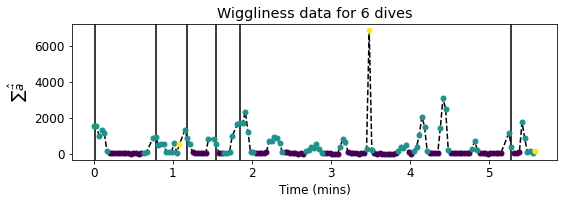

In [22]:
if model != 'CarHHMM1':
    colors = [cm.get_cmap('viridis')(i/(hhmm.pars.K[1]-1.0)) for i in range(hhmm.pars.K[1])]

    plt.figure(figsize=(8,3))
    plt.plot(t[3],w[3],'k--')

    for start in starts:
        plt.axvline(start,color='k')

    for i in range(3):
        plt.plot(t[i],w[i],'.',color=colors[i],markersize=10)


    plt.title('Wiggliness data for 6 dives')
    plt.ylabel(r'$\sum \hat \vec a$');
    plt.xlabel('Time (mins)')

    plt.tight_layout()
    plt.savefig('temp.png',dpi=300)

# Visualize Results

In [23]:
print(hhmm.theta[0])
print(hhmm.theta[1][0])
print('')
print(hhmm.eta[0])
for eta0 in hhmm.eta[1]:
    print(eta0)
print('')
print(HHMM.eta_2_ptm(hhmm.eta[0]))
for eta0 in hhmm.eta[1]:
    print(HHMM.eta_2_ptm(eta0))

{'dive_duration': {'mu': array([ 27.3419, 127.5479]), 'sig': array([10.9613, 63.8877]), 'corr': array([-0.6285,  0.7114])}}
{'Ahat_low': {'mu': array([  34.0145,  490.0683, 9154.1558]), 'sig': array([   22.986 ,   502.5584, 13538.747 ]), 'corr': array([-1.0185,  0.3487, -3.0756])}, 'Ax': {'mu': array([0.4491, 0.2102, 0.2324]), 'sig': array([0.0392, 0.0959, 0.2956]), 'corr': array([3.4086, 1.5791, 0.4341])}, 'Ay': {'mu': array([0.4502, 0.4371, 0.3662]), 'sig': array([0.051 , 0.0938, 0.3652]), 'corr': array([3.4086, 1.5791, 0.4341])}, 'Az': {'mu': array([-0.691 , -0.573 , -0.3029]), 'sig': array([0.058 , 0.1111, 0.3542]), 'corr': array([3.4086, 1.5791, 0.4341])}}

[[ 0.     -1.7127]
 [ 2.3629  0.    ]]
[[  0.      -1.0783  -5.9046]
 [ -2.3897   0.      -2.819 ]
 [-36.9357  -1.2166   0.    ]]
[[  0.      -2.051  -34.1086]
 [ -1.6947   0.      -3.1301]
 [-35.3201  -1.2369   0.    ]]

[[0.8472 0.1528]
 [0.914  0.086 ]]
[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]

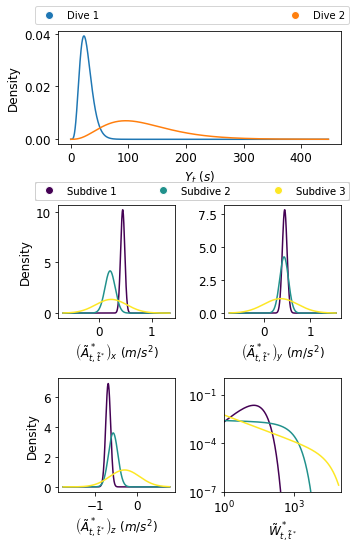

In [24]:
fig = plt.figure(figsize = (5,7.5))

gs = GridSpec(3,2)

ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1,0])
ax3=fig.add_subplot(gs[1,1])
ax4=fig.add_subplot(gs[2,0])
ax5=fig.add_subplot(gs[2,1])

axs = [ax2,ax3,ax4,ax5]

# Coarse Scale
            
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']

dist = pars.features[0]['dive_duration']['f']
K = pars.K[0]
colors = [cm.get_cmap('tab10')(i) for i in range(K)]
legend = ['Dive %d'%(x+1) for x in range(K)]

for state in range(K):
    if dist == 'gamma':
        shape = np.square(mu)/np.square(sig)
        scale = np.square(sig)/np.array(mu)
        x = np.linspace(0.01,max(mu)+5*max(sig),100000)
        y = gamma.pdf(x,shape[state],0,scale[state])
    elif dist == 'normal':
        x = np.linspace(min(mu)-3*max(sig),max(mu)+3*max(sig),100000)
        y = norm.pdf(x,mu[state],sig[state])
    elif dist == 'vonmises':
        x = np.linspace(-np.pi,np.pi,100000)
        y = vonmises.pdf(x,sig[state],loc=mu[state])
    else:
        raise('distribution %s not recognized' % dist)
    ax1.plot(x,y,color=colors[state])
    ax1.set_ylabel('Density',fontsize=12)
    ax1.set_xlabel('$Y_t$ $(s)$')
    
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Dive 1',
                       markerfacecolor=colors[0], markersize=8)]

if model != 'CarHMM':
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Dive 2',
                                  markerfacecolor=colors[1], markersize=8))

fig.legend(handles=legend_elements,
           prop={'size': 10}, ncol=2,
           mode='expand',
           bbox_to_anchor=(0.1, 0.975, 0.9, 0.5),
           loc='lower left')

if model != "CarHHMM1":
    fine_features=['Ax','Ay','Az','Ahat_low']
else:
    fine_features=['Ax','Ay','Az']

# fine scale
for feature_num,feature in enumerate(fine_features):

    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']

    dist = pars.features[1][feature]['f']
    K = pars.K[1]
    colors = [cm.get_cmap('viridis')(i) for i in [0.,0.5,1.]]
    legend = ['Subdive %d'%(x+1) for x in range(K)]
    
    # order s

    for state in range(K):
        if dist == 'gamma':
            shape = np.square(mu)/np.square(sig)
            scale = np.square(sig)/np.array(mu)
            x = np.linspace(0.01,max(mu)+5*max(sig),100000)
            y = gamma.pdf(x,shape[state],0,scale[state])
        elif dist == 'normal':
            x = np.linspace(min(mu)-3*max(sig),max(mu)+3*max(sig),100000)
            y = norm.pdf(x,mu[state],sig[state])
        elif dist == 'vonmises':
            x = np.linspace(-np.pi,np.pi,100000)
            y = vonmises.pdf(x,sig[state],loc=mu[state])
        else:
            raise('distribution %s not recognized' % dist)
        axs[feature_num].plot(x,y,color=colors[state])
        if feature_num%2 == 0:
            axs[feature_num].set_ylabel('Density',fontsize=12)
        titles = [r'$\left(\tilde A^*_{t,\tilde t^*}\right)_x$ $(m/s^2)$',
                  r'$\left(\tilde A^*_{t,\tilde t^*}\right)_y$ $(m/s^2)$',
                  r'$\left(\tilde A^*_{t,\tilde t^*}\right)_z$ $(m/s^2)$',
                  r'$\tilde W^*_{t,\tilde t^*}$']
        title = titles[feature_num]
        axs[feature_num].set_xlabel(title,fontsize=12)
        if feature == 'Ahat_low':
            axs[feature_num].set_xscale('log')
            axs[feature_num].set_yscale('log')
            axs[feature_num].set_ylim([10e-8,10e-1])
            axs[feature_num].set_xlim([10e-1,10e4])

        legend_elements = [Line2D([0], [0], marker='o', color='w', label='Subdive 1',
                               markerfacecolor=colors[0], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label='Subdive 2',
                               markerfacecolor=colors[1], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label='Subdive 3',
                               markerfacecolor=colors[2], markersize=8)]

        fig.legend(handles=legend_elements,
                   prop={'size': 10}, ncol=3,
                   mode='expand',
                   bbox_to_anchor=(0.1, 0.65, 0.9, 0.5),
                   loc='lower left')

plt.tight_layout()
bbox = Bbox([[0,0],[5,8]])
file = '../Plots/%s/%s_%s_%s_%s_all_emissions.png' % (year,whale,s_dive,e_dive,model)
plt.savefig(file,bbox_inches=bbox,dpi=500)
plt.show()

-20250.575938838094
Probability transistion matrix for Dive types:
[[0.8472 0.1528]
 [0.914  0.086 ]]

Stationary distribution for dive types:
[[0.8567 0.1433]]




Probability transistion matrix for subdive behaviors, dive type 1:
[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]

Stationary Distribution for subdive behaviors, dive type 1:
[[0.2023 0.6488 0.1489]]


Probability transistion matrix for subdive behaviors, dive type 2:
[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]

Stationary Distribution for subdive behaviors, dive type 2:
[[0.5313 0.4046 0.0641]]




/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code/Visualisor.py:509: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



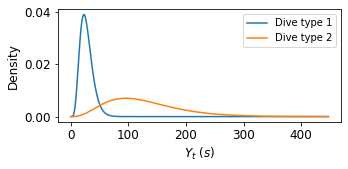

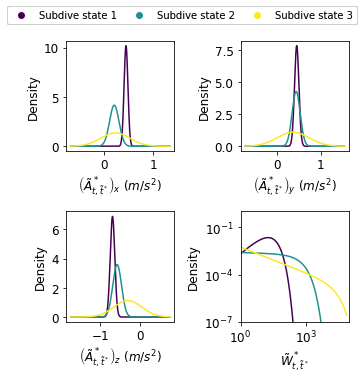

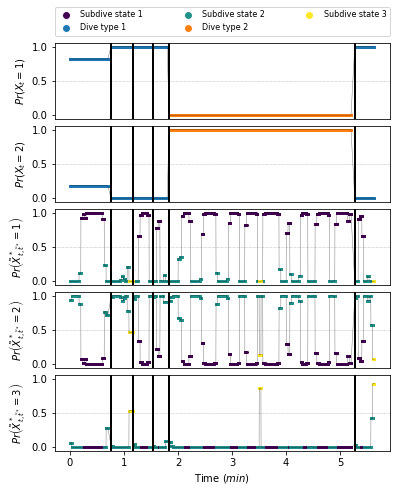

/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code/Visualisor.py:509: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



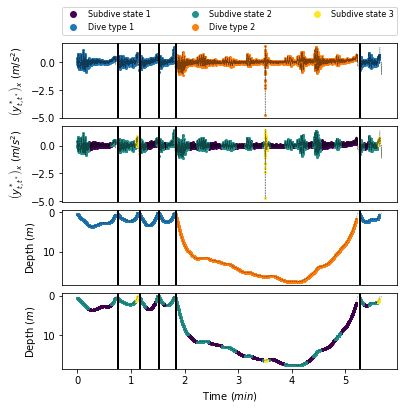

In [25]:
print(hhmm.likelihood(deep_data))

sdive = 160
edive = 165

importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.hhmm = hhmm
#rcParams.update({'figure.autolayout': True})
viz.plot_emission_probs(0,file='../Plots/%s/%s_%s_%s_%s-coarse-emissions.png'%(year,whale,s_dive,e_dive,model))
if model == 'CarHHMM1':
    viz.plot_emission_probs(1,
                            file='../Plots/%s/%s_%s_%s_%s-fine-emissions.png' % (year,whale,s_dive,e_dive,model),
                            features=['Ax','Ay','Az'])
else:
    viz.plot_emission_probs(1,file='../Plots/%s/%s_%s_%s_%s-fine-emissions.png' % (year,whale,s_dive,e_dive,model))
viz.print_ptms()
if model != 'CarHMM':
    viz.plot_dive_features(sdive,edive,['dive_state_0_prob',
                                    'dive_state_1_prob',
                                    'subdive_state_0_prob',
                                    'subdive_state_1_prob',
                                    'subdive_state_2_prob'],[],
                           file = '../Plots/%s/%s_%s_%s_%s_decoded_states.png' % (year,whale,s_dive,e_dive,model),
                           nrows = 5)
else:
    viz.plot_dive_features(sdive,edive,['dive_state_0_prob',
                                    'subdive_state_0_prob',
                                    'subdive_state_1_prob',
                                    'subdive_state_2_prob'],[],
                           ylabs = [r'$Pr\left(X_t = 1\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 1\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 2\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 3\right)$'],
                           file = '../Plots/%s/%s_%s_%s_%s_decoded_states.png' % (year,whale,s_dive,e_dive,model),
                           nrows = 4)
    
plt.show()

viz.plot_dive_features(sdive,edive,['Ax','depth'],[],
                       file = '../Plots/%s/%s_%s_%s_%s_decoded_dives.png' % (year,whale,s_dive,e_dive,model),
                       ylabs = [r'$\left(y^*_{t,t^*}\right)_x$ $(m/s^2)$',r'Depth $(m)$'],
                       nrows = 4)

In [26]:
'''
hhmm.theta[0]['dive_duration']['mu'] = np.array([19.481,57.330,44.278])
hhmm.theta[0]['dive_duration']['sig'] = np.array([4.798,53.621,48.755])

for i in range(3):
    hhmm.theta[1][i]['Ahat_low']['mu'] = np.array([22.385, 680.147, 5000.986])
    hhmm.theta[1][i]['Ahat_low']['sig'] = np.array([13.883, 753.257, 6079.488])
    
    hhmm.theta[1][i]['Ax']['mu'] = np.array([0.109,0.0207, -0.0752])
    hhmm.theta[1][i]['Ax']['sig'] = np.array([0.0262,0.0851,0.393])
    hhmm.theta[1][i]['Ax']['corr'] = np.array([1.705,-0.154,0.644])
    
    hhmm.theta[1][i]['Ay']['mu'] = np.array([0.271,0.169,0.160])
    hhmm.theta[1][i]['Ay']['sig'] = np.array([0.0378,0.0969,0.407])
    hhmm.theta[1][i]['Ay']['corr'] = np.array([1.705,-0.154,0.644])
    
    hhmm.theta[1][i]['Az']['mu'] = np.array([-0.0947,-0.0919,-0.411])
    hhmm.theta[1][i]['Az']['sig'] = np.array([0.0203,0.0604,0.431])
    hhmm.theta[1][i]['Az']['corr'] = np.array([1.705,-0.154,0.644])
    
hhmm.eta[0] = np.array([[0.,38.449, -8.456],
                        [1.351 , 0., -2.556],
                        [-3.319, -33.8275, 0.]])

hhmm.eta[1][0] = np.array([[0.0, -0.915, -34.204],
                           [-1.566, 0.0, -3.156],
                           [-35.718, 0.439, 0.0]])

hhmm.eta[1][1] = np.array([[0.0, -1.333, -8.064],
                           [-1.643, 0.0, -3.605],
                           [-36.476, -1.389, 0.0]])

hhmm.eta[1][2] = np.array([[0.0, -0.319, -41.542],
                           [-4.141, 0.0, -1.169],
                           [-38.222, -1.750, 0.0]])

hhmm.save(HHMM_file)
'''

"\nhhmm.theta[0]['dive_duration']['mu'] = np.array([19.481,57.330,44.278])\nhhmm.theta[0]['dive_duration']['sig'] = np.array([4.798,53.621,48.755])\n\nfor i in range(3):\n    hhmm.theta[1][i]['Ahat_low']['mu'] = np.array([22.385, 680.147, 5000.986])\n    hhmm.theta[1][i]['Ahat_low']['sig'] = np.array([13.883, 753.257, 6079.488])\n    \n    hhmm.theta[1][i]['Ax']['mu'] = np.array([0.109,0.0207, -0.0752])\n    hhmm.theta[1][i]['Ax']['sig'] = np.array([0.0262,0.0851,0.393])\n    hhmm.theta[1][i]['Ax']['corr'] = np.array([1.705,-0.154,0.644])\n    \n    hhmm.theta[1][i]['Ay']['mu'] = np.array([0.271,0.169,0.160])\n    hhmm.theta[1][i]['Ay']['sig'] = np.array([0.0378,0.0969,0.407])\n    hhmm.theta[1][i]['Ay']['corr'] = np.array([1.705,-0.154,0.644])\n    \n    hhmm.theta[1][i]['Az']['mu'] = np.array([-0.0947,-0.0919,-0.411])\n    hhmm.theta[1][i]['Az']['sig'] = np.array([0.0203,0.0604,0.431])\n    hhmm.theta[1][i]['Az']['corr'] = np.array([1.705,-0.154,0.644])\n    \nhhmm.eta[0] = np.array(

# Histograms over emission distributions

267


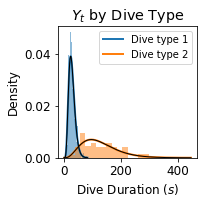

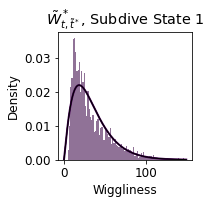

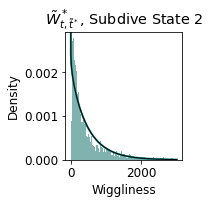

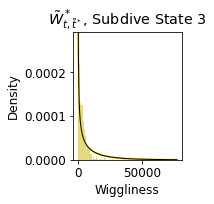

Ax


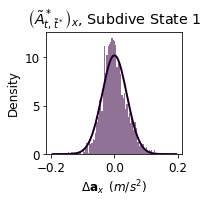

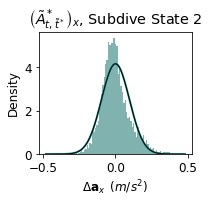

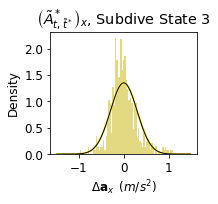

Ay


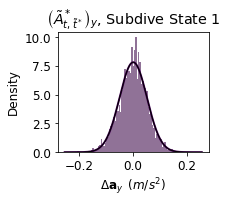

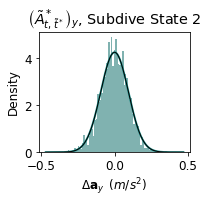

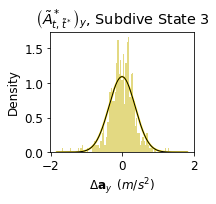

Az


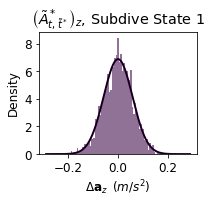

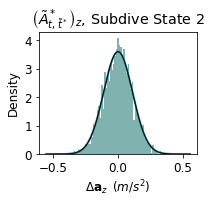

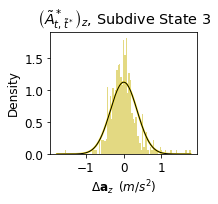

In [48]:
# colors
dive_colors = [cm.get_cmap('tab10')(i) for i in range(hhmm.pars.K[0])]
subdive_colors = [cm.get_cmap('viridis')(i/(hhmm.pars.K[1]-1.0)) for i in range(hhmm.pars.K[1])]

# dive duration
weights = [list([]) for _ in range(hhmm.pars.K[0])]
values = []

for dive in data:
    for i in range(hhmm.pars.K[0]):
        weights[i].append(dive['dive_state_probs'][i])
    values.append(dive['dive_duration'])
        
print(len(weights[0]))
        
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)



plt.figure(figsize=(3,3))
for state in range(hhmm.pars.K[0]):
    bins = np.linspace(0.01,mu[state]+5*sig[state],25)
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.hist(values,weights=weights[state],density=True,bins=bins,color=dive_colors[state],alpha=0.5)
    plt.plot(x,y,color=dive_colors[state],linewidth=2)

plt.legend(['Dive type %s' % (i+1) for i in range(hhmm.pars.K[0])],fontsize=10)

for state in range(hhmm.pars.K[0]):
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.plot(x,y,color='k',linewidth=1)
    
plt.title('$Y_t$ by Dive Type')
plt.ylabel('Density')
plt.xlabel('Dive Duration $(s)$')
plt.tight_layout()
plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_dive_duration.png' % (year,whale,s_dive,e_dive,model),
            dpi=500)
plt.show()
    
# A-hat
if model != 'CarHHMM1':
    weights = [list([]) for _ in range(hhmm.pars.K[1])]
    values = []

    for dive in data:
        for seg in dive['subdive_features']:
            weights[0].append(seg['subdive_state_probs'][0])
            weights[1].append(seg['subdive_state_probs'][1])
            weights[2].append(seg['subdive_state_probs'][2])
            values.append(seg['Ahat_low'])

    mu = hhmm.theta[1][0]['Ahat_low']['mu']
    sig = hhmm.theta[1][0]['Ahat_low']['sig']
    shape = np.square(mu)/np.square(sig)
    scale = np.square(sig)/np.array(mu)
    for state in range(hhmm.pars.K[1]):
        plt.figure(figsize=(3,3))
        bins = np.linspace(0.01,mu[state]+5*sig[state],100)
        plt.hist(values,weights=weights[state],density=True,bins=bins,color=subdive_colors[state],alpha=0.5)
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        x = np.linspace(0.01,mu[state]+5*sig[state],10000)
        y = gamma.pdf(x,shape[state],0,scale[state])
        plt.plot(x,y,color='k',linewidth=1)
        plt.title(r'$\tilde W^*_{t,\tilde t^*}$, Subdive State %d'%(state+1))
        plt.xlim(xlim)
        plt.xlabel('Wiggliness')
        plt.ylim(ylim)
        plt.ylabel('Density')
        #plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=12)
        plt.hist(values,weights=weights[state],density=True,bins=bins,color='k',alpha=0.1)
        plt.plot(x,y,color=subdive_colors[state],linewidth=2)
        plt.plot(x,y,color='k',linewidth=1)
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_ahat_%d.png' % (year,whale,s_dive,e_dive,model,state),
            dpi=500)
        plt.show()
    
    
# Ax
for feature in ['Ax','Ay','Az']:
    print(feature)
    weights = [list([]) for _ in range(hhmm.pars.K[1])]
    values = [list([]) for _ in range(hhmm.pars.K[1])]

    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    if model == 'HHMM':
        corr = np.zeros(hhmm.pars.K[1])
    else:
        corr = expit(hhmm.theta[1][0][feature]['corr'])

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                weights[state].append(seg['subdive_state_probs'][state])
                values[state].append(seg[feature] - (corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]))
                seg_tm1 = seg
                
    for state in range(hhmm.pars.K[1]):
        plt.figure(figsize=(3,3))
        bins = np.linspace(-5*sig[state],5*sig[state],100)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color=subdive_colors[state],alpha=0.5)
        x = np.linspace(-5*sig[state],5*sig[state],10000)
        y = norm.pdf(x,0,sig[state])
        plt.plot(x,y,color=subdive_colors[state],linewidth=2)
        plt.ylabel('Density')
        plt.xlabel('$\Delta \mathbf{a}_%s \enspace (m/s^2)$'%feature[-1])
        plt.title(r'$\left(\tilde A^*_{t,\tilde t^*}\right)_%s$, Subdive State %d'%(feature[-1],state+1))
        #plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=12)
        plt.plot(x,y,color='k',linewidth=1)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color='k',alpha=0.1)
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_%s_%d' % (year,whale,s_dive,e_dive,model,feature,state),
                    dpi=500)
        plt.show()

# Psuedoresiduals

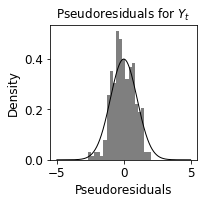

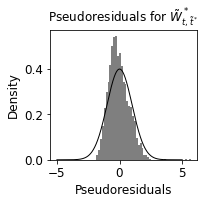

Ax


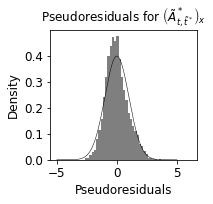

Ay


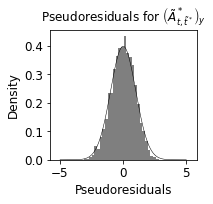

Az


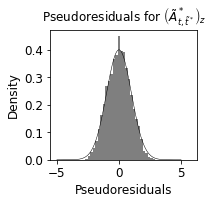

In [28]:
x = np.linspace(-5,5,1000)
y = norm.pdf(x)

# dive duration
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

psuedoresids = []

for dive in data:
    cdf = 0
    for state in range(hhmm.pars.K[0]):
        cdf += dive['dive_state_probs'][state] * \
               gamma.cdf(dive['dive_duration'],
                         shape[state],0,scale[state])
    if cdf >= 1.0:
        cdf = 0.9999
        
    psuedoresids.append(norm.ppf(cdf))

plt.figure(figsize=(3,3))
plt.hist(psuedoresids,density=True,bins=20,color='k',alpha=0.5)
plt.title(r'Pseudoresiduals for $Y_t$', fontsize=12)
plt.plot(x,y,color='k',linewidth=1)
plt.xlabel('Pseudoresiduals')
plt.ylabel('Density')
#plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
plt.tight_layout()
plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_dive_duration.png' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

# A-hat
if model != 'CarHHMM1':
    mu = hhmm.theta[1][0]['Ahat_low']['mu']
    sig = hhmm.theta[1][0]['Ahat_low']['sig']
    shape = np.square(mu)/np.square(sig)
    scale = np.square(sig)/np.array(mu)

    psuedoresids = []

    for dive in data:
        for seg in dive['subdive_features']:
            cdf = 0
            for state in range(hhmm.pars.K[1]):
                cdf += seg['subdive_state_probs'][state] * \
                        gamma.cdf(seg['Ahat_low'],shape[state],0,scale[state])
            if cdf >= 1.0:
                cdf = 0.9999
            psuedoresids.append(norm.ppf(cdf))

    plt.figure(figsize=(3,3))     
    plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
    plt.title(r'Pseudoresiduals for $\tilde W^*_{t,\tilde t^*}$', fontsize=12)
    plt.plot(x,y,color='k',linewidth=1)
    plt.xlabel('Pseudoresiduals')
    plt.ylabel('Density')
    #plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
    plt.tight_layout()
    plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_ahat.png' % (year,whale,s_dive,e_dive,model),dpi=500)
    plt.show() 

for feature in ['Ax','Ay','Az']:
    print(feature)
    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    if model == 'HHMM':
        corr = np.zeros(hhmm.pars.K[1])
    else:
        corr = expit(hhmm.theta[1][0][feature]['corr'])
    
    psuedoresids = []

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                cdf = 0
                for state in range(hhmm.pars.K[1]):
                    mean = corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]
                    cdf += seg['subdive_state_probs'][state] * \
                            norm.cdf(seg[feature],mean,sig[state])
                seg_tm1 = seg
                if cdf >= 1.0:
                    cdf = 0.9999
                psuedoresids.append(norm.ppf(cdf))
                
    plt.figure(figsize=(3,3))
    plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
    plt.plot(x,y,color='k',linewidth=0.5)
    plt.title(r'Pseudoresiduals for $\left(\tilde A^*_{t,\tilde t^*}\right)_%s$'%feature[-1], fontsize=12)
    plt.xlabel('Pseudoresiduals')
    plt.ylabel('Density')
    #plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=10)
    plt.tight_layout()
    plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_%s.png' % (year,whale,s_dive,e_dive,model,feature),dpi=500)
    plt.show()   

# Make Tables

In [29]:
if model == 'CarHHMM2':
    table = r'''
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive type / subdive state} & \multicolumn{3}{c}{Parameter estimate}  \\
                                                                                   &                                      & $\hat \mu$    & $\hat \sigma$ & $\hat \phi$   \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ -- $Y_t$}                                  & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---           \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---           \\ \hline
    \multirow{3}{*}{$x$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_x$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{$y$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_y$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{$z$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_z$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{Wiggliness -- $\Ztwo_{t,\tilde t^*}$}                          & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---           \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---           \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---           \\ \hline
    \end{tabular}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)
    
elif model == 'CarHHMM1':
    
    table = r'''
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}        \\
                                                                                   &                                      & $\hat \mu$    & $\hat \sigma$ & $\hat \phi$   \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ -- $Y_t$}                                  & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---           \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---           \\ \hline
    \multirow{3}{*}{$x$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_x$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{$y$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_y$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{$z$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_z$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \end{tabular}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2])

    print(table)
    
elif model == 'HHMM':
    
    table = r'''
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}          \\
                                                                                   &                                      & $\hat \mu$    & $\hat \sigma$ & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ -- $Y_t$}                                  & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{$x$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_x$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{$y$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_y$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{$z$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_z$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{Wiggliness -- $\Ztwo_{t,\tilde t^*}$}                           & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \end{tabular}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)
    
elif model == 'CarHMM':
    
    table = r'''
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}        \\
                                                                                   &                                      & $\hat \mu$    & $\hat \sigma$ & $\hat \phi$   \\ \hline
    \multirow{1}{*}{Dive Duration $(s)$ -- $Y_t$}                                  & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---           \\ \hline
    \multirow{3}{*}{$x$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_x$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{$y$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_y$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{$z$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_z$}   & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{Wiggliness -- $\Ztwo_{t,\tilde t^*}$}                          & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---           \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---           \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---           \\ \hline
    \end{tabular}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)


    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive type / subdive state} & \multicolumn{3}{c}{Parameter estimate}        \\
                                                                                   &                                      & $\hat \mu$    & $\hat \sigma$ & $\hat \phi$   \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ -- $Y_t$}                                  & 1                                    & $27.342 (0.633)$ & $10.961 (0.560)$ & ---           \\
                                                                                   & 2                                    & $127.548 (11.341)$ & $63.888 (9.032)$ & ---           \\ \hline
    \multirow{3}{*}{$x$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_x$}   & 1                                    & $0.449 (0.030)$ & $0.039 (0.001)$ & $0.968 (0.002)$ \\
                                                                   

In [30]:
if model != 'CarHMM':
    ptm = HHMM.eta_2_ptm(hhmm.eta[0])
    delta = np.array([0.5,0.5])
    for _ in range(100):
        delta = delta.dot(ptm)

    gamma0 = r'''$$\hat \Gamma = \begin{pmatrix} 
    %.3f & %.3f \\
    %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta = \begin{pmatrix} %.3f & %.3f \end{pmatrix}$$
    '''% tuple(np.concatenate([ptm.flatten(),delta]))

    print(gamma0)

$$\hat \Gamma = \begin{pmatrix} 
    0.847 & 0.153 \\
    0.914 & 0.086
    \end{pmatrix}$$
    $$\hat \delta = \begin{pmatrix} 0.857 & 0.143 \end{pmatrix}$$
    


In [31]:
ptm1 = HHMM.eta_2_ptm(hhmm.eta[1][0])
delta1 = np.array([0.3333,0.3333,0.3334])
for _ in range(100):
    delta1 = delta1.dot(ptm1)
    
if model != 'CarHMM':
    
    ptm2 = HHMM.eta_2_ptm(hhmm.eta[1][1])
    delta2 = np.array([0.3333,0.3333,0.3334])
    for _ in range(100):
        delta2 = delta2.dot(ptm2)

    gamma0 = r'''$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(1)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$

    $$\hat \Gamma^{*(2)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(2)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$
    ''' % tuple(np.concatenate([ptm1.flatten(),delta1,ptm2.flatten(),delta2]))
    
else:
    
    gamma0 = r'''$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(1)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$
    ''' % tuple(np.concatenate([ptm1.flatten(),delta1]))
    
print(gamma0)

$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
    0.745 & 0.253 & 0.002 \\
    0.080 & 0.869 & 0.052 \\
    0.000 & 0.229 & 0.771
    \end{pmatrix}$$
    $$\hat \delta^{*(1)} = \begin{pmatrix} 0.202 & 0.649 & 0.149 \end{pmatrix}$$

    $$\hat \Gamma^{*(2)} = \begin{pmatrix} 
    0.886 & 0.114 & 0.000 \\
    0.150 & 0.815 & 0.036 \\
    0.000 & 0.225 & 0.775
    \end{pmatrix}$$
    $$\hat \delta^{*(2)} = \begin{pmatrix} 0.531 & 0.405 & 0.064 \end{pmatrix}$$
    


# Make plots of likelihood

In [37]:
labels = {'Ahat_low': r'$\tilde W^*_{t,\tilde t^*}$',
          'Ax': r'$\left(\tilde A^*_{t,\tilde t^*}\right)_x$',
          'Ay': r'$\left(\tilde A^*_{t,\tilde t^*}\right)_y$',
          'Az': r'$\left(\tilde A^*_{t,\tilde t^*}\right)_z$',
          'dive_duration': r'$Y_t$'}

In [42]:
hhmm = hhmm.load(HHMM_file)
orig_l = hhmm.likelihood(data)

In [43]:
# coarse-scale theta
for feature in []:#hhmm.theta[0]:
    print('')
    print(feature)
    
    for state_num in range(pars.K[0]):
        print('')
        print(state_num)
        
        orig_mu = float(hhmm.theta[0][feature]['mu'][state_num])
        orig_sig = float(hhmm.theta[0][feature]['sig'][state_num])
        ls = np.zeros((n_points,n_points))
        
        # get ranges to iterate through
        mus = np.linspace(orig_mu - 5*hhmm.SEs[feature]['mu'][state_num],
                          orig_mu + 5*hhmm.SEs[feature]['mu'][state_num],
                          n_points)
        
        sigs = np.linspace(orig_sig - 5*hhmm.SEs[feature]['sig'][state_num],
                           orig_sig + 5*hhmm.SEs[feature]['sig'][state_num],
                           n_points)
        
        #if feature in ['Ax','Ay','Az']:
        #    mus = np.linspace(orig_mu-0.1,orig_mu+0.1,n_points)
        #    sigs = np.linspace(orig_sig*0.9,orig_sig*1.1,n_points)
        #else:
        #    mus = np.linspace(orig_mu*0.9,orig_mu*1.1,n_points)
        #    sigs = np.linspace(orig_sig*0.9,orig_sig*1.1,n_points)
        
        for i,mu in enumerate(mus):
            hhmm.theta[0][feature]['mu'][state_num] = mu
            for j,sig in enumerate(sigs):
                hhmm.theta[0][feature]['sig'][state_num] = sig
                ls[i,j] = hhmm.likelihood(data) - orig_l
                
        hhmm.theta[0][feature]['mu'][state_num] = orig_mu
        hhmm.theta[0][feature]['sig'][state_num] = orig_sig
        
        # make a heatmap
        cmap = plt.cm.viridis
        cmap.set_under()
        plt.imshow(np.rot90(ls), cmap=cmap,
                   vmin = -5, vmax = 0,
                   extent = [mus[0],mus[-1]] + [sigs[0],sigs[-1]], 
                   aspect='auto')
        plt.plot(orig_mu,orig_sig,'r*')
        c = plt.colorbar()
        c.set_label('$\Delta \log(\mathcal{L}_{HMM})$')
        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$\sigma$')
        plt.title(labels[feature] + ', Dive Type ' + str(state_num+1))
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_coarse-theta-likelihood-%s-%d.png' % (year,whale,s_dive,e_dive,model,feature,state_num+1),dpi=500)
        plt.show()

In [44]:
# coarse-scale gamma
if False:
    orig_gamma = HHMM.eta_2_ptm(hhmm.eta[0])
    orig_eta = deepcopy(hhmm.eta[0])

    ls = np.zeros((n_points,n_points))

    # get ranges to iterate through
    gamma_12s = np.linspace(max(10e-8,orig_gamma[0,1] - 5*hhmm.SEs['Gamma_coarse'][0,1]),
                            min(1.0-10e-8,orig_gamma[0,1] + 5*hhmm.SEs['Gamma_coarse'][0,1]),
                            n_points)

    gamma_21s = np.linspace(max(10e-8,orig_gamma[1,0] - 5*hhmm.SEs['Gamma_coarse'][1,0]),
                            min(1.0-10e-8,orig_gamma[1,0] + 5*hhmm.SEs['Gamma_coarse'][1,0]),
                            n_points)

    for i,gamma_12 in enumerate(gamma_12s):
        for j,gamma_21 in enumerate(gamma_21s):
            gamma0 = np.array([[1.0-gamma_12,gamma_12],
                              [gamma_21,1.0-gamma_21]])
            hhmm.eta[0] = HHMM.ptm_2_eta(gamma0)
            ls[i,j] = hhmm.likelihood(data) - orig_l
            print(hhmm.eta[0])
            print(orig_eta)
            print(ls[i,j])
            print('')

    hhmm.eta[0] = orig_eta

    cmap = plt.cm.viridis
    cmap.set_under()
    plt.imshow(np.rot90(ls), vmin = -5, vmax = 0, cmap=cmap,
               extent = [gamma_12s[0],gamma_12s[-1]] + [gamma_21s[0],gamma_21s[-1]], 
               aspect='auto')

    gamma0 = HHMM.eta_2_ptm(hhmm.eta[0])
    plt.plot(gamma0[0,1],gamma0[1,0],'r*')
    c = plt.colorbar()
    c.set_label('$\Delta \log(\mathcal{L}_{HMM})$')
    plt.xlabel(r'$\Gamma_{1,2}$')
    plt.ylabel(r'$\Gamma_{2,1}$')
    plt.title(r'Log-likelihood vs $\Gamma$')
    plt.tight_layout()
    plt.savefig('../Plots/%s/%s_%s_%s_%s_coarse-gamma-likelihood.png' % (year,whale,s_dive,e_dive,model),dpi=500)
    plt.show()


Ahat_low

0
[-4.     -3.5789 -3.1579 -2.7368 -2.3158 -1.8947 -1.4737 -1.0526 -0.6316
 -0.2105  0.2105  0.6316  1.0526  1.4737  1.8947  2.3158  2.7368  3.1579
  3.5789  4.    ]


/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))



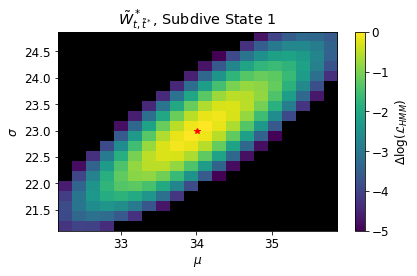


1
[-4.     -3.5789 -3.1579 -2.7368 -2.3158 -1.8947 -1.4737 -1.0526 -0.6316
 -0.2105  0.2105  0.6316  1.0526  1.4737  1.8947  2.3158  2.7368  3.1579
  3.5789  4.    ]


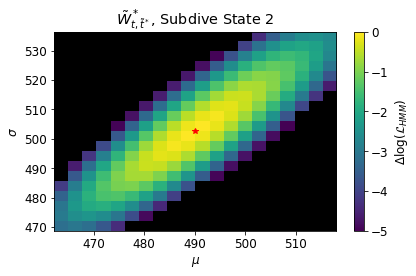


2
[-4.     -3.5789 -3.1579 -2.7368 -2.3158 -1.8947 -1.4737 -1.0526 -0.6316
 -0.2105  0.2105  0.6316  1.0526  1.4737  1.8947  2.3158  2.7368  3.1579
  3.5789  4.    ]


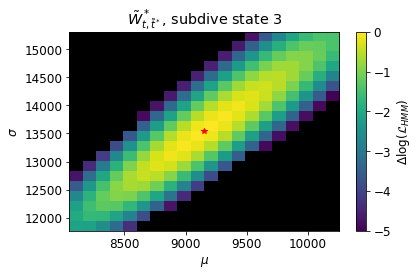


Ax

0
[3.135  3.1688 3.2026 3.2364 3.2702 3.3041 3.3379 3.3717 3.4055 3.4393
 3.4731 3.507  3.5408 3.5746 3.6084 3.6422 3.676  3.7099 3.7437 3.7775]


/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))



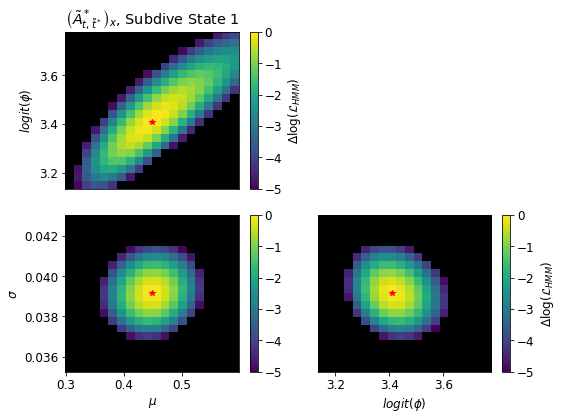


1
[1.348  1.3745 1.4011 1.4276 1.4541 1.4806 1.5072 1.5337 1.5602 1.5867
 1.6133 1.6398 1.6663 1.6928 1.7194 1.7459 1.7724 1.7989 1.8255 1.852 ]


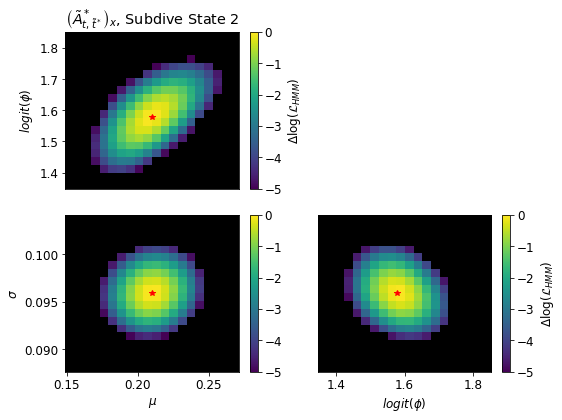


2
[-0.0381  0.0144  0.067   0.1196  0.1721  0.2247  0.2772  0.3298  0.3824
  0.4349  0.4875  0.5401  0.5926  0.6452  0.6977  0.7503  0.8029  0.8554
  0.908   0.9605]


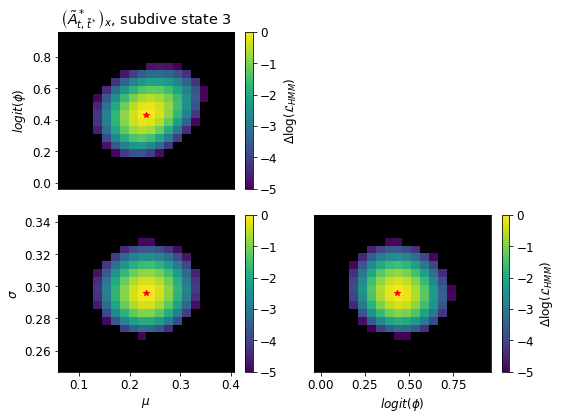


Ay

0
[3.135  3.1688 3.2026 3.2364 3.2702 3.3041 3.3379 3.3717 3.4055 3.4393
 3.4731 3.507  3.5408 3.5746 3.6084 3.6422 3.676  3.7099 3.7437 3.7775]


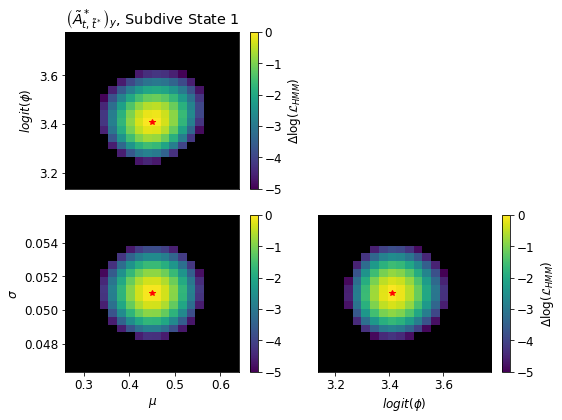


1
[1.348  1.3745 1.4011 1.4276 1.4541 1.4806 1.5072 1.5337 1.5602 1.5867
 1.6133 1.6398 1.6663 1.6928 1.7194 1.7459 1.7724 1.7989 1.8255 1.852 ]


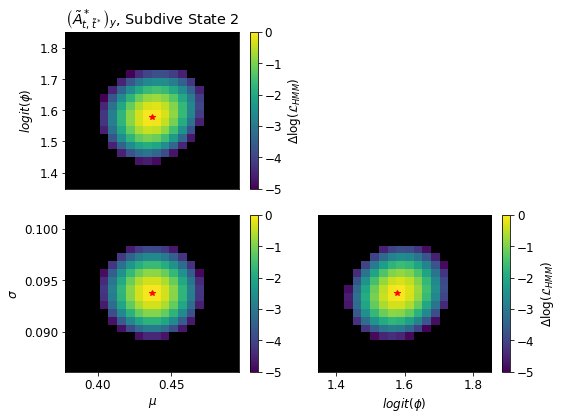


2
[-0.0381  0.0144  0.067   0.1196  0.1721  0.2247  0.2772  0.3298  0.3824
  0.4349  0.4875  0.5401  0.5926  0.6452  0.6977  0.7503  0.8029  0.8554
  0.908   0.9605]


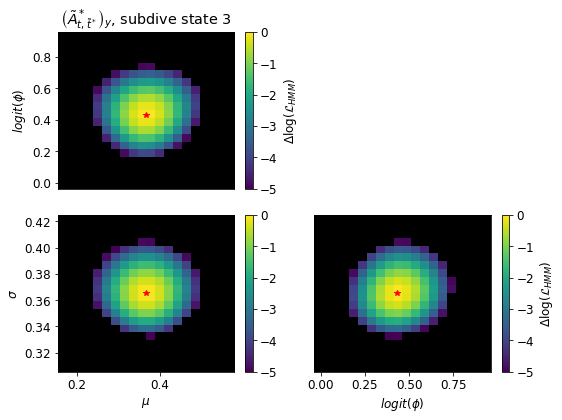


Az

0
[3.135  3.1688 3.2026 3.2364 3.2702 3.3041 3.3379 3.3717 3.4055 3.4393
 3.4731 3.507  3.5408 3.5746 3.6084 3.6422 3.676  3.7099 3.7437 3.7775]


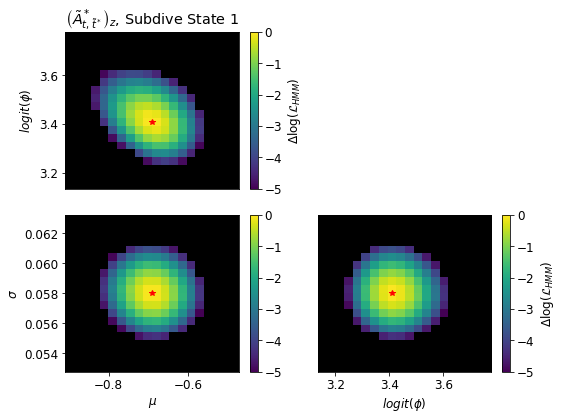


1
[1.348  1.3745 1.4011 1.4276 1.4541 1.4806 1.5072 1.5337 1.5602 1.5867
 1.6133 1.6398 1.6663 1.6928 1.7194 1.7459 1.7724 1.7989 1.8255 1.852 ]


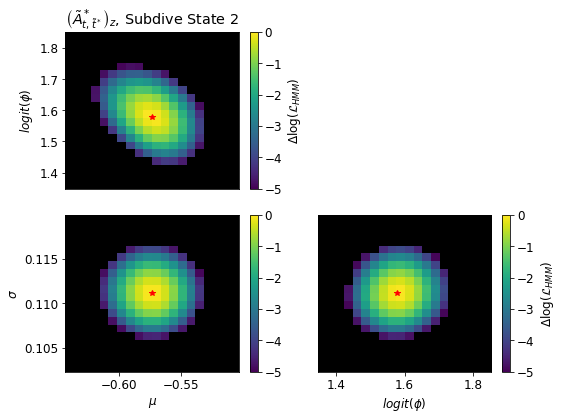


2
[-0.0381  0.0144  0.067   0.1196  0.1721  0.2247  0.2772  0.3298  0.3824
  0.4349  0.4875  0.5401  0.5926  0.6452  0.6977  0.7503  0.8029  0.8554
  0.908   0.9605]


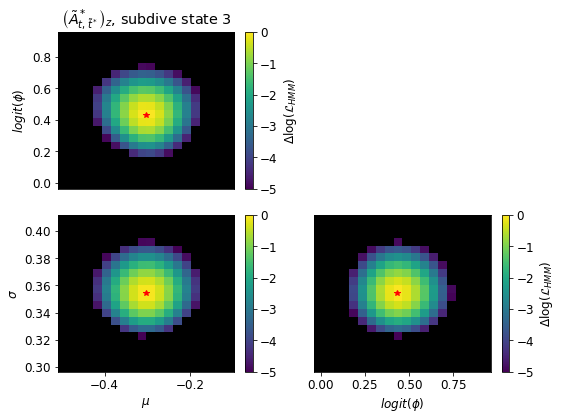

In [45]:
# fine-scale theta
fine_scale_theta_ls = {}
for feature in hhmm.theta[1][0]:
    
    print('')
    print(feature)
    fine_scale_theta_ls[feature] = {}
    
    for state_num in range(pars.K[1]):
        print('')
        print(state_num)
        fine_scale_theta_ls[feature][state_num] = []
        
        orig_mu = float(hhmm.theta[1][0][feature]['mu'][state_num])
        orig_sig = float(hhmm.theta[1][0][feature]['sig'][state_num])
        orig_corr = float(hhmm.theta[1][0][feature]['corr'][state_num])
        ls = np.zeros((n_points,n_points))
        
        # get ranges to iterate through
        mus = np.linspace(orig_mu - 5*hhmm.SEs[feature]['mu'][state_num],
                          orig_mu + 5*hhmm.SEs[feature]['mu'][state_num],
                          n_points)
        
        sigs = np.linspace(orig_sig - 5*hhmm.SEs[feature]['sig'][state_num],
                           orig_sig + 5*hhmm.SEs[feature]['sig'][state_num],
                           n_points)
        
        corr_low = logit(expit(orig_corr)-5*hhmm.SEs[feature]['corr'][state_num])
        corr_high = logit(expit(orig_corr)+5*hhmm.SEs[feature]['corr'][state_num])
        
        if np.isnan(corr_low):
            corr_low = -4.0
        if np.isnan(corr_high):
            corr_high = 4.0
        
        corrs = np.linspace(corr_low,corr_high,n_points)
        
        print(corrs)

        for i,mu in enumerate(mus):
            hhmm.theta[1][0][feature]['mu'][state_num] = mu
            hhmm.theta[1][1][feature]['mu'][state_num] = mu
            for j,sig in enumerate(sigs):
                hhmm.theta[1][0][feature]['sig'][state_num] = sig
                hhmm.theta[1][1][feature]['sig'][state_num] = sig
                ls[i,j] = hhmm.likelihood(data) - orig_l
                
        fine_scale_theta_ls[feature][state_num].append(ls)
                
        hhmm.theta[1][0][feature]['mu'][state_num] = orig_mu
        hhmm.theta[1][0][feature]['sig'][state_num] = orig_sig
        hhmm.theta[1][1][feature]['mu'][state_num] = orig_mu
        hhmm.theta[1][1][feature]['sig'][state_num] = orig_sig
        
        if feature in ['Ax','Ay','Az']:
            fig, axs = plt.subplots(2,2,figsize = (8,6))
            fig.delaxes(axs[0,1])
            plt.subplot(2,2,3)
        
        # make a heatmap
        cmap = plt.cm.viridis
        cmap.set_under()
        plt.imshow(np.rot90(ls), cmap=cmap,
                   vmin = -5, vmax = 0,
                   extent = [mus[0],mus[-1]] + [sigs[0],sigs[-1]], 
                   aspect='auto')
        c = plt.colorbar()
        plt.plot(orig_mu,orig_sig,'r*')
        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$\sigma$')
        
        if feature not in ['Ax','Ay','Az']:
            c.set_label('$\Delta \log(\mathcal{L}_{HMM})$')
            if state_num < 2:
                plt.title(labels[feature] + ', Subdive State ' + str(state_num+1))
            else:
                plt.title(labels[feature] + ', subdive state ' + str(state_num+1))
        if feature in ['Ax','Ay','Az']:
            plt.subplot(2,2,1)
            for i,mu in enumerate(mus):
                hhmm.theta[1][0][feature]['mu'][state_num] = mu
                hhmm.theta[1][1][feature]['mu'][state_num] = mu
                for j,corr in enumerate(corrs):
                    hhmm.theta[1][0]['Ax']['corr'][state_num] = corr
                    hhmm.theta[1][1]['Ax']['corr'][state_num] = corr
                    hhmm.theta[1][0]['Ay']['corr'][state_num] = corr
                    hhmm.theta[1][1]['Ay']['corr'][state_num] = corr
                    hhmm.theta[1][0]['Az']['corr'][state_num] = corr
                    hhmm.theta[1][1]['Az']['corr'][state_num] = corr
                    ls[i,j] = hhmm.likelihood(data) - orig_l
                    
            fine_scale_theta_ls[feature][state_num].append(ls)

            hhmm.theta[1][0][feature]['mu'][state_num] = orig_mu
            hhmm.theta[1][1][feature]['mu'][state_num] = orig_mu
            hhmm.theta[1][1]['Ax']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Ax']['corr'][state_num] = orig_corr
            hhmm.theta[1][1]['Ay']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Ay']['corr'][state_num] = orig_corr
            hhmm.theta[1][1]['Az']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Az']['corr'][state_num] = orig_corr
            
            cmap = plt.cm.viridis
            cmap.set_under()
            plt.imshow(np.rot90(ls), vmin = -5, vmax = 0, cmap=cmap,
                       extent = [mus[0],mus[-1]] + [corrs[0],corrs[-1]], 
                       aspect = 'auto')
            plt.plot(orig_mu,orig_corr,'r*')
            c = plt.colorbar()
            c.set_label('$\Delta \log(\mathcal{L}_{HMM})$')
            plt.xticks([])
            plt.ylabel(r'$logit(\phi)$')
            if state_num < 2:
                plt.title(labels[feature] + ', Subdive State ' + str(state_num+1))
            else:
                plt.title(labels[feature] + ', subdive state ' + str(state_num+1))

            
            plt.subplot(2,2,4)
            for i,corr in enumerate(corrs):
                hhmm.theta[1][0]['Ax']['corr'][state_num] = corr
                hhmm.theta[1][1]['Ax']['corr'][state_num] = corr
                hhmm.theta[1][0]['Ay']['corr'][state_num] = corr
                hhmm.theta[1][1]['Ay']['corr'][state_num] = corr
                hhmm.theta[1][0]['Az']['corr'][state_num] = corr
                hhmm.theta[1][1]['Az']['corr'][state_num] = corr
                for j,sig in enumerate(sigs):
                    hhmm.theta[1][0][feature]['sig'][state_num] = sig
                    hhmm.theta[1][1][feature]['sig'][state_num] = sig
                    ls[i,j] = hhmm.likelihood(data) - orig_l

            fine_scale_theta_ls[feature][state_num].append(ls)
            
            hhmm.theta[1][0][feature]['sig'][state_num] = orig_sig
            hhmm.theta[1][1][feature]['sig'][state_num] = orig_sig
            hhmm.theta[1][1]['Ax']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Ax']['corr'][state_num] = orig_corr
            hhmm.theta[1][1]['Ay']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Ay']['corr'][state_num] = orig_corr
            hhmm.theta[1][1]['Az']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Az']['corr'][state_num] = orig_corr
            
            cmap = plt.cm.viridis
            cmap.set_under()
            plt.imshow(np.rot90(ls), vmin = -5, vmax = 0, cmap=cmap,
                       extent = [corrs[0],corrs[-1]] + [sigs[0],sigs[-1]], 
                       aspect='auto')
            plt.plot(orig_corr,orig_sig,'r*')
            c = plt.colorbar()
            c.set_label('$\Delta \log(\mathcal{L}_{HMM})$')
            plt.xlabel(r'$logit(\phi)$')
            plt.yticks([])
         
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_fine-theta-likelihood-%s-%d.png' % (year,whale,s_dive,e_dive,model,feature,state_num),dpi=500)
        plt.show()
        
        with open('fine_scale_theta_ls', 'wb') as handle:
            pickle.dump(fine_scale_theta_ls, handle)

0
0
[[0.8334 0.1666 0.    ]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-17.361233563362475

[[0.8325 0.1666 0.0009]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-16.588217739506945

[[0.8316 0.1666 0.0018]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-16.158907153952896

[[0.8307 0.1666 0.0027]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-15.886792247267294

[[0.8298 0.1666 0.0036]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-15.71013551460419

[[0.8289 0.1666 0.0045]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-15.599702545423497

[[0.828  0.1666 0.0054]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-15.538932106614084

[[0.8271 0.1666 0.0063]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-15.517359171390126

[[0.8262 0.1666 0.0072]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-15.527864384854183

[[0.8253 0.1666 0.0081]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-15.565339471530024

[[0.8244 0.1666 0.009 ]
 [0.0796 0.8686 0.0518]
 [0.     

[[0.7897 0.2031 0.0072]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-4.946704904657963

[[0.7888 0.2031 0.0081]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-5.08944490920112

[[0.7879 0.2031 0.009 ]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-5.252559278560511

[[0.787  0.2031 0.0099]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-5.433447494164284

[[0.7861 0.2031 0.0108]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-5.630047898306657

[[0.7852 0.2031 0.0117]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-5.840692426681926

[[0.7843 0.2031 0.0126]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-6.064008170087618

[[0.7834 0.2031 0.0135]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-6.298848529069801

[[0.7825 0.2031 0.0144]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-6.544243758489756

[[0.7816 0.2031 0.0153]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-6.7993646129762055

[[0.7807 0.2031 0.0162]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715

[[0.746  0.2396 0.0144]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-3.1714561818625953

[[0.7451 0.2396 0.0153]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-3.492688609559991

[[0.7442 0.2396 0.0162]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-3.821922312501556

[[0.7433 0.2396 0.0171]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-4.158594170869037

[[0.7512 0.2488 0.    ]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-0.43573313579690875

[[0.7503 0.2488 0.0009]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-0.13875899696722627

[[0.7494 0.2488 0.0018]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-0.04044761841578293

[[0.7485 0.2488 0.0027]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-0.0483509347322979

[[0.7477 0.2488 0.0036]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-0.124783096525789

[[0.7468 0.2488 0.0045]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-0.2501882038923213

[[0.7459 0.2488 0.0054]
 [0.0796 0.8686 0.0518]
 [0.     0.22

[[0.7111 0.2853 0.0036]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-1.7998341814054584

[[0.7102 0.2853 0.0045]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-1.9936529074220743

[[0.7093 0.2853 0.0054]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-2.2207195203554875

[[0.7084 0.2853 0.0063]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-2.4744047263884568

[[0.7075 0.2853 0.0072]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-2.7500579771585763

[[0.7066 0.2853 0.0081]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-3.044268410096265

[[0.7057 0.2853 0.009 ]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-3.3544461807468906

[[0.7048 0.2853 0.0099]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-3.6785695074540854

[[0.704  0.2853 0.0108]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-4.0150237981797545

[[0.7031 0.2853 0.0117]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-4.362494974928268

[[0.7022 0.2853 0.0126]
 [0.0796 0.8686 0.0518]
 [0.     0.228

[[0.6674 0.3218 0.0108]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-9.57282779588786

[[0.6665 0.3218 0.0117]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-9.960017671699461

[[0.6656 0.3218 0.0126]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-10.356221194877435

[[0.6647 0.3218 0.0135]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-10.760610154960887

[[0.6638 0.3218 0.0144]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-11.172480452365562

[[0.6629 0.3218 0.0153]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-11.591227357017488

[[0.662  0.3218 0.0162]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-12.016326770593878

[[0.6611 0.3218 0.0171]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-12.447320803294133

[[0.6691 0.3309 0.    ]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-8.266170325729036

[[0.6682 0.3309 0.0009]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0.7715]]
-8.240289405894146

[[0.6673 0.3309 0.0018]
 [0.0796 0.8686 0.0518]
 [0.     0.2285 0

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))



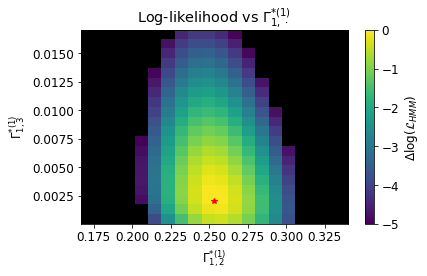

1
[[0.7447 0.2533 0.002 ]
 [0.0439 0.9335 0.0226]
 [0.     0.2285 0.7715]]
-36.26326526886987

[[0.7447 0.2533 0.002 ]
 [0.0439 0.9304 0.0257]
 [0.     0.2285 0.7715]]
-31.55165661755018

[[0.7447 0.2533 0.002 ]
 [0.0439 0.9273 0.0288]
 [0.     0.2285 0.7715]]
-27.778237802838703

[[0.7447 0.2533 0.002 ]
 [0.0439 0.9243 0.0318]
 [0.     0.2285 0.7715]]
-24.7783803450875

[[0.7447 0.2533 0.002 ]
 [0.0439 0.9212 0.0349]
 [0.     0.2285 0.7715]]
-22.42830423666601

[[0.7447 0.2533 0.002 ]
 [0.0439 0.9181 0.038 ]
 [0.     0.2285 0.7715]]
-20.63253453757352

[[0.7447 0.2533 0.002 ]
 [0.0439 0.915  0.0411]
 [0.     0.2285 0.7715]]
-19.315814898101962

[[0.7447 0.2533 0.002 ]
 [0.0439 0.912  0.0441]
 [0.     0.2285 0.7715]]
-18.417692051123595

[[0.7447 0.2533 0.002 ]
 [0.0439 0.9089 0.0472]
 [0.     0.2285 0.7715]]
-17.888788236781693

[[0.7447 0.2533 0.002 ]
 [0.0439 0.9058 0.0503]
 [0.     0.2285 0.7715]]
-17.688178668915498

[[0.7447 0.2533 0.002 ]
 [0.0439 0.9027 0.0534]
 [0.     0.2285 

[[0.7447 0.2533 0.002 ]
 [0.0589 0.8939 0.0472]
 [0.     0.2285 0.7715]]
-5.284795834533725

[[0.7447 0.2533 0.002 ]
 [0.0589 0.8908 0.0503]
 [0.     0.2285 0.7715]]
-5.035337542707566

[[0.7447 0.2533 0.002 ]
 [0.0589 0.8877 0.0534]
 [0.     0.2285 0.7715]]
-5.079482411802019

[[0.7447 0.2533 0.002 ]
 [0.0589 0.8846 0.0564]
 [0.     0.2285 0.7715]]
-5.3881983262836

[[0.7447 0.2533 0.002 ]
 [0.0589 0.8816 0.0595]
 [0.     0.2285 0.7715]]
-5.936635265341465

[[0.7447 0.2533 0.002 ]
 [0.0589 0.8785 0.0626]
 [0.     0.2285 0.7715]]
-6.703338144667214

[[0.7447 0.2533 0.002 ]
 [0.0589 0.8754 0.0657]
 [0.     0.2285 0.7715]]
-7.669641103922913

[[0.7447 0.2533 0.002 ]
 [0.0589 0.8723 0.0687]
 [0.     0.2285 0.7715]]
-8.819194725223497

[[0.7447 0.2533 0.002 ]
 [0.0589 0.8693 0.0718]
 [0.     0.2285 0.7715]]
-10.137592036637216

[[0.7447 0.2533 0.002 ]
 [0.0589 0.8662 0.0749]
 [0.     0.2285 0.7715]]
-11.612068976588489

[[0.7447 0.2533 0.002 ]
 [0.0589 0.8631 0.078 ]
 [0.     0.2285 0.7715

[[0.7447 0.2533 0.002 ]
 [0.074  0.8542 0.0718]
 [0.     0.2285 0.7715]]
-5.204714081624843

[[0.7447 0.2533 0.002 ]
 [0.074  0.8511 0.0749]
 [0.     0.2285 0.7715]]
-6.642416607992345

[[0.7447 0.2533 0.002 ]
 [0.074  0.8481 0.078 ]
 [0.     0.2285 0.7715]]
-8.225031650577876

[[0.7447 0.2533 0.002 ]
 [0.074  0.845  0.081 ]
 [0.     0.2285 0.7715]]
-9.942483768281818

[[0.7447 0.2533 0.002 ]
 [0.0777 0.8997 0.0226]
 [0.     0.2285 0.7715]]
-19.358191621162405

[[0.7447 0.2533 0.002 ]
 [0.0777 0.8966 0.0257]
 [0.     0.2285 0.7715]]
-14.583627626947418

[[0.7447 0.2533 0.002 ]
 [0.0777 0.8935 0.0288]
 [0.     0.2285 0.7715]]
-10.740070413405192

[[0.7447 0.2533 0.002 ]
 [0.0777 0.8904 0.0318]
 [0.     0.2285 0.7715]]
-7.665207291775005

[[0.7447 0.2533 0.002 ]
 [0.0777 0.8874 0.0349]
 [0.     0.2285 0.7715]]
-5.2366219436516985

[[0.7447 0.2533 0.002 ]
 [0.0777 0.8843 0.038 ]
 [0.     0.2285 0.7715]]
-3.3595682798368216

[[0.7447 0.2533 0.002 ]
 [0.0777 0.8812 0.0411]
 [0.     0.2285 0

[[0.7447 0.2533 0.002 ]
 [0.0928 0.8723 0.0349]
 [0.     0.2285 0.7715]]
-6.841958177443303

[[0.7447 0.2533 0.002 ]
 [0.0928 0.8692 0.038 ]
 [0.     0.2285 0.7715]]
-4.950929130020086

[[0.7447 0.2533 0.002 ]
 [0.0928 0.8662 0.0411]
 [0.     0.2285 0.7715]]
-3.534289769911993

[[0.7447 0.2533 0.002 ]
 [0.0928 0.8631 0.0441]
 [0.     0.2285 0.7715]]
-2.5322836246850784

[[0.7447 0.2533 0.002 ]
 [0.0928 0.86   0.0472]
 [0.     0.2285 0.7715]]
-1.896059616257844

[[0.7447 0.2533 0.002 ]
 [0.0928 0.8569 0.0503]
 [0.     0.2285 0.7715]]
-1.5851589634257834

[[0.7447 0.2533 0.002 ]
 [0.0928 0.8539 0.0534]
 [0.     0.2285 0.7715]]
-1.5656832176573516

[[0.7447 0.2533 0.002 ]
 [0.0928 0.8508 0.0564]
 [0.     0.2285 0.7715]]
-1.8089330948241695

[[0.7447 0.2533 0.002 ]
 [0.0928 0.8477 0.0595]
 [0.     0.2285 0.7715]]
-2.290381046546827

[[0.7447 0.2533 0.002 ]
 [0.0928 0.8446 0.0626]
 [0.     0.2285 0.7715]]
-2.9888851575415174

[[0.7447 0.2533 0.002 ]
 [0.0928 0.8416 0.0657]
 [0.     0.2285 0

[[0.7447 0.2533 0.002 ]
 [0.1078 0.8327 0.0595]
 [0.     0.2285 0.7715]]
-7.1244671666718205

[[0.7447 0.2533 0.002 ]
 [0.1078 0.8296 0.0626]
 [0.     0.2285 0.7715]]
-7.806338445425354

[[0.7447 0.2533 0.002 ]
 [0.1078 0.8265 0.0657]
 [0.     0.2285 0.7715]]
-8.686272418748558

[[0.7447 0.2533 0.002 ]
 [0.1078 0.8235 0.0687]
 [0.     0.2285 0.7715]]
-9.748310053033492

[[0.7447 0.2533 0.002 ]
 [0.1078 0.8204 0.0718]
 [0.     0.2285 0.7715]]
-10.978406566035119

[[0.7447 0.2533 0.002 ]
 [0.1078 0.8173 0.0749]
 [0.     0.2285 0.7715]]
-12.364130383004522

[[0.7447 0.2533 0.002 ]
 [0.1078 0.8142 0.078 ]
 [0.     0.2285 0.7715]]
-13.894419624557486

[[0.7447 0.2533 0.002 ]
 [0.1078 0.8112 0.081 ]
 [0.     0.2285 0.7715]]
-15.559383451764006

[[0.7447 0.2533 0.002 ]
 [0.1116 0.8658 0.0226]
 [0.     0.2285 0.7715]]
-27.49697320359701

[[0.7447 0.2533 0.002 ]
 [0.1116 0.8627 0.0257]
 [0.     0.2285 0.7715]]
-22.754972233178705

[[0.7447 0.2533 0.002 ]
 [0.1116 0.8597 0.0288]
 [0.     0.2285 

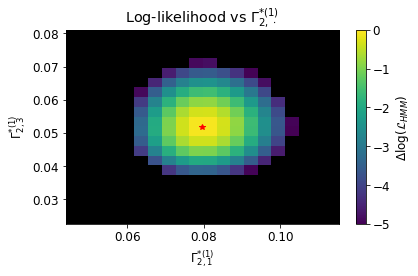

2
[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.1207 0.8793]]
-18.905922728357837

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.132  0.868 ]]
-14.362611155669583

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.1434 0.8566]]
-10.638289252427057

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.1547 0.8453]]
-7.619647037205141

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.1661 0.8339]]
-5.213281877393456

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.1774 0.8226]]
-3.341442784138053

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.1888 0.8112]]
-1.9388791706951451

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.2001 0.7999]]
-0.9504510719089012

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.2115 0.7885]]
-0.3292799110713531

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.2229 0.7771]]
-0.03529250110295834

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.     0.2

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0105 0.2115 0.778 ]]
-4.361992376125272

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0105 0.2229 0.7666]]
-4.156159869988187

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0105 0.2342 0.7553]]
-4.229927428532392

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0105 0.2456 0.7439]]
-4.555475836190453

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0105 0.2569 0.7326]]
-5.108580352840363

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0105 0.2683 0.7212]]
-5.868018464290799

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0105 0.2796 0.7099]]
-6.81507565888387

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0105 0.291  0.6985]]
-7.933131858924753

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0105 0.3023 0.6871]]
-9.207316419848212

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0105 0.3137 0.6758]]
-10.624223660724965

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0105 0.325  0.6644

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0211 0.3023 0.6766]]
-13.640977024944732

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0211 0.3137 0.6653]]
-15.07624846647741

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0211 0.325  0.6539]]
-16.637514980247943

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0211 0.3364 0.6426]]
-18.314021596899693

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0237 0.1207 0.8556]]
-24.68694157273785

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0237 0.132  0.8443]]
-20.83382129392703

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0237 0.1434 0.8329]]
-17.692283139498613

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0237 0.1547 0.8216]]
-15.1668390306113

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0237 0.1661 0.8102]]
-13.178637229681044

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0237 0.1774 0.7989]]
-11.661896822672134

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0237 0.1888 0

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0342 0.1661 0.7997]]
-16.817585409964522

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0342 0.1774 0.7884]]
-15.433248401313904

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0342 0.1888 0.777 ]]
-14.445731858268118

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0342 0.2001 0.7656]]
-13.811022646768834

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0342 0.2115 0.7543]]
-13.491506895250495

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0342 0.2229 0.7429]]
-13.454825134122075

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0342 0.2342 0.7316]]
-13.672955569571059

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0342 0.2456 0.7202]]
-14.121470774047339

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0342 0.2569 0.7089]]
-14.778929389303812

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0342 0.2683 0.6975]]
-15.626375821422698

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0342 0.2

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0447 0.2569 0.6984]]
-19.054359392430342

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0447 0.2683 0.687 ]]
-19.93518809802481

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0447 0.2796 0.6756]]
-20.98328700442653

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0447 0.291  0.6643]]
-22.18404069467215

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0447 0.3023 0.6529]]
-23.52423122017717

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0447 0.3137 0.6416]]
-24.99186374888086

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0447 0.325  0.6302]]
-26.576042400454753

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0447 0.3364 0.6189]]
-28.266886306733795

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0474 0.1207 0.832 ]]
-31.23736839488265

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0474 0.132  0.8206]]
-27.915715484941757

[[0.7447 0.2533 0.002 ]
 [0.0796 0.8686 0.0518]
 [0.0474 0.1434 0.

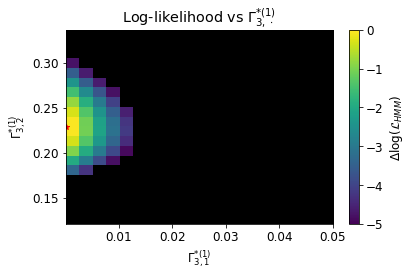

1
0
[[0.9321 0.0679 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-16.440985949899186

[[0.9295 0.0679 0.0026]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-16.524150916276994

[[0.9268 0.0679 0.0053]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-17.57183457854626

[[0.9242 0.0679 0.0079]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-19.015023319010652

[[0.9216 0.0679 0.0105]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-20.69681429105549

[[0.919  0.0679 0.0132]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-22.54608717985684

[[0.9163 0.0679 0.0158]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-24.523164947535406

[[0.9137 0.0679 0.0184]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-26.60309432122449

[[0.9111 0.0679 0.0211]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-28.768891899700975

[[0.9084 0.0679 0.0237]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-31.00832956000886

[[0.9058 0.0679 0.0263]
 [0.1496 0.8148 0.0356]
 [0.     0.22

[[0.8917 0.0873 0.0211]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-19.526129383135412

[[0.889  0.0873 0.0237]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-21.96653901101672

[[0.8864 0.0873 0.0263]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-24.464613732252474

[[0.8838 0.0873 0.0289]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-27.01404772508613

[[0.8811 0.0873 0.0316]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-29.60981711227214

[[0.8785 0.0873 0.0342]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-32.24783270233456

[[0.8759 0.0873 0.0368]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-34.92470575257539

[[0.8732 0.0873 0.0395]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-37.637584672334924

[[0.8706 0.0873 0.0421]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-40.38403795380145

[[0.868  0.0873 0.0447]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-43.16196820250116

[[0.8653 0.0873 0.0474]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.7

[[0.8512 0.1067 0.0421]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-39.0031609749567

[[0.8486 0.1067 0.0447]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-41.92095606143994

[[0.846  0.1067 0.0474]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-44.86603098248452

[[0.8433 0.1067 0.05  ]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-47.836935792129225

[[0.8885 0.1115 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-0.03495817994189565

[[0.8858 0.1115 0.0026]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-1.1820320515034837

[[0.8832 0.1115 0.0053]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-2.9221295175484556

[[0.8806 0.1115 0.0079]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-4.949591975546355

[[0.8779 0.1115 0.0105]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-7.158791934914916

[[0.8753 0.1115 0.0132]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-9.498115764894465

[[0.8727 0.1115 0.0158]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.

[[0.8586 0.1309 0.0105]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-9.610400717225275

[[0.8559 0.1309 0.0132]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-12.116183135127358

[[0.8533 0.1309 0.0158]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-14.714103216392687

[[0.8507 0.1309 0.0184]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-17.386845385615743

[[0.848  0.1309 0.0211]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-20.12245278589762

[[0.8454 0.1309 0.0237]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-22.912246675459755

[[0.8428 0.1309 0.0263]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-25.74968013184116

[[0.8401 0.1309 0.0289]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-28.629660199389036

[[0.8375 0.1309 0.0316]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-31.548124145851034

[[0.8349 0.1309 0.0342]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-34.50176239242137

[[0.8322 0.1309 0.0368]
 [0.1496 0.8148 0.0356]
 [0.     0.225  

[[0.8181 0.1503 0.0316]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-38.482148642007814

[[0.8155 0.1503 0.0342]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-41.5528338144577

[[0.8128 0.1503 0.0368]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-44.65389873186359

[[0.8102 0.1503 0.0395]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-47.783188981855346

[[0.8076 0.1503 0.0421]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-50.93886289143484

[[0.805  0.1503 0.0447]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-54.11932704500214

[[0.8023 0.1503 0.0474]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-57.32318781379581

[[0.7997 0.1503 0.05  ]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-60.54921428359012

[[0.8448 0.1552 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-8.408345366580761

[[0.8422 0.1552 0.0026]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775 ]]
-10.19813466089181

[[0.8396 0.1552 0.0053]
 [0.1496 0.8148 0.0356]
 [0.     0.225  0.775

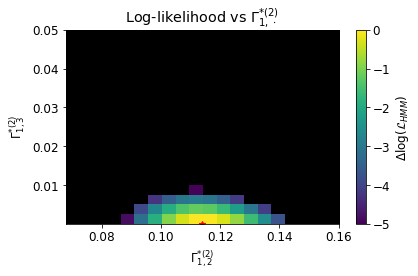

1
[[0.8861 0.1139 0.    ]
 [0.0834 0.9166 0.    ]
 [0.     0.225  0.775 ]]
-112.87756436649579

[[0.8861 0.1139 0.    ]
 [0.0834 0.9128 0.0038]
 [0.     0.225  0.775 ]]
-45.12508529907791

[[0.8861 0.1139 0.    ]
 [0.0834 0.909  0.0076]
 [0.     0.225  0.775 ]]
-35.27111733386482

[[0.8861 0.1139 0.    ]
 [0.0834 0.9051 0.0114]
 [0.     0.225  0.775 ]]
-29.53735162360681

[[0.8861 0.1139 0.    ]
 [0.0834 0.9013 0.0152]
 [0.     0.225  0.775 ]]
-25.665416138177534

[[0.8861 0.1139 0.    ]
 [0.0834 0.8975 0.019 ]
 [0.     0.225  0.775 ]]
-22.898600324577274

[[0.8861 0.1139 0.    ]
 [0.0834 0.8937 0.0228]
 [0.     0.225  0.775 ]]
-20.90168927584091

[[0.8861 0.1139 0.    ]
 [0.0834 0.8899 0.0267]
 [0.     0.225  0.775 ]]
-19.490240570161404

[[0.8861 0.1139 0.    ]
 [0.0834 0.8861 0.0305]
 [0.     0.225  0.775 ]]
-18.545264234813658

[[0.8861 0.1139 0.    ]
 [0.0834 0.8823 0.0343]
 [0.     0.225  0.775 ]]
-17.98234707645679

[[0.8861 0.1139 0.    ]
 [0.0834 0.8785 0.0381]
 [0.     0.225 

[[0.8861 0.1139 0.    ]
 [0.1113 0.8582 0.0305]
 [0.     0.225  0.775 ]]
-5.560916275549971

[[0.8861 0.1139 0.    ]
 [0.1113 0.8544 0.0343]
 [0.     0.225  0.775 ]]
-5.1200552876143774

[[0.8861 0.1139 0.    ]
 [0.1113 0.8506 0.0381]
 [0.     0.225  0.775 ]]
-4.984515711952554

[[0.8861 0.1139 0.    ]
 [0.1113 0.8468 0.0419]
 [0.     0.225  0.775 ]]
-5.109102426391473

[[0.8861 0.1139 0.    ]
 [0.1113 0.843  0.0457]
 [0.     0.225  0.775 ]]
-5.458290629183466

[[0.8861 0.1139 0.    ]
 [0.1113 0.8392 0.0495]
 [0.     0.225  0.775 ]]
-6.003617916936491

[[0.8861 0.1139 0.    ]
 [0.1113 0.8354 0.0533]
 [0.     0.225  0.775 ]]
-6.721935695899447

[[0.8861 0.1139 0.    ]
 [0.1113 0.8316 0.0571]
 [0.     0.225  0.775 ]]
-7.594172150198574

[[0.8861 0.1139 0.    ]
 [0.1113 0.8278 0.0609]
 [0.     0.225  0.775 ]]
-8.604430032781238

[[0.8861 0.1139 0.    ]
 [0.1113 0.824  0.0647]
 [0.     0.225  0.775 ]]
-9.739316303915984

[[0.8861 0.1139 0.    ]
 [0.1113 0.8202 0.0685]
 [0.     0.225  0.775

[[0.8861 0.1139 0.    ]
 [0.1392 0.7999 0.0609]
 [0.     0.225  0.775 ]]
-4.52085082873964

[[0.8861 0.1139 0.    ]
 [0.1392 0.7961 0.0647]
 [0.     0.225  0.775 ]]
-5.727929829288769

[[0.8861 0.1139 0.    ]
 [0.1392 0.7923 0.0685]
 [0.     0.225  0.775 ]]
-7.044732285452483

[[0.8861 0.1139 0.    ]
 [0.1392 0.7885 0.0724]
 [0.     0.225  0.775 ]]
-8.461961525215884

[[0.8861 0.1139 0.    ]
 [0.1461 0.8539 0.    ]
 [0.     0.225  0.775 ]]
-88.69771123405008

[[0.8861 0.1139 0.    ]
 [0.1461 0.85   0.0038]
 [0.     0.225  0.775 ]]
-24.08023331321965

[[0.8861 0.1139 0.    ]
 [0.1461 0.8462 0.0076]
 [0.     0.225  0.775 ]]
-14.750150188414409

[[0.8861 0.1139 0.    ]
 [0.1461 0.8424 0.0114]
 [0.     0.225  0.775 ]]
-9.367751870089705

[[0.8861 0.1139 0.    ]
 [0.1461 0.8386 0.0152]
 [0.     0.225  0.775 ]]
-5.903208687930601

[[0.8861 0.1139 0.    ]
 [0.1461 0.8348 0.019 ]
 [0.     0.225  0.775 ]]
-3.5620806285332947

[[0.8861 0.1139 0.    ]
 [0.1461 0.831  0.0228]
 [0.     0.225  0.775

[[0.8861 0.1139 0.    ]
 [0.174  0.8108 0.0152]
 [0.     0.225  0.775 ]]
-6.59021520346505

[[0.8861 0.1139 0.    ]
 [0.174  0.8069 0.019 ]
 [0.     0.225  0.775 ]]
-4.408758539822884

[[0.8861 0.1139 0.    ]
 [0.174  0.8031 0.0228]
 [0.     0.225  0.775 ]]
-2.981096856874501

[[0.8861 0.1139 0.    ]
 [0.174  0.7993 0.0267]
 [0.     0.225  0.775 ]]
-2.1005333103530575

[[0.8861 0.1139 0.    ]
 [0.174  0.7955 0.0305]
 [0.     0.225  0.775 ]]
-1.64021942704494

[[0.8861 0.1139 0.    ]
 [0.174  0.7917 0.0343]
 [0.     0.225  0.775 ]]
-1.5163052342140872

[[0.8861 0.1139 0.    ]
 [0.174  0.7879 0.0381]
 [0.     0.225  0.775 ]]
-1.6702887005376397

[[0.8861 0.1139 0.    ]
 [0.174  0.7841 0.0419]
 [0.     0.225  0.775 ]]
-2.0595269794066553

[[0.8861 0.1139 0.    ]
 [0.174  0.7803 0.0457]
 [0.     0.225  0.775 ]]
-2.6517415030721168

[[0.8861 0.1139 0.    ]
 [0.174  0.7765 0.0495]
 [0.     0.225  0.775 ]]
-3.4216971746827767

[[0.8861 0.1139 0.    ]
 [0.174  0.7727 0.0533]
 [0.     0.225  0.

[[0.8861 0.1139 0.    ]
 [0.2019 0.7524 0.0457]
 [0.     0.225  0.775 ]]
-7.8832555033841345

[[0.8861 0.1139 0.    ]
 [0.2019 0.7486 0.0495]
 [0.     0.225  0.775 ]]
-8.767326073331787

[[0.8861 0.1139 0.    ]
 [0.2019 0.7448 0.0533]
 [0.     0.225  0.775 ]]
-9.803502778318943

[[0.8861 0.1139 0.    ]
 [0.2019 0.741  0.0571]
 [0.     0.225  0.775 ]]
-10.975624091784994

[[0.8861 0.1139 0.    ]
 [0.2019 0.7372 0.0609]
 [0.     0.225  0.775 ]]
-12.270363931078464

[[0.8861 0.1139 0.    ]
 [0.2019 0.7334 0.0647]
 [0.     0.225  0.775 ]]
-13.676559434425144

[[0.8861 0.1139 0.    ]
 [0.2019 0.7296 0.0685]
 [0.     0.225  0.775 ]]
-15.184734740982094

[[0.8861 0.1139 0.    ]
 [0.2019 0.7258 0.0724]
 [0.     0.225  0.775 ]]
-16.78675584155644

[[0.8861 0.1139 0.    ]
 [0.2089 0.7911 0.    ]
 [0.     0.225  0.775 ]]
-89.00509664699348

[[0.8861 0.1139 0.    ]
 [0.2089 0.7873 0.0038]
 [0.     0.225  0.775 ]]
-28.467517634089745

[[0.8861 0.1139 0.    ]
 [0.2089 0.7835 0.0076]
 [0.     0.225  

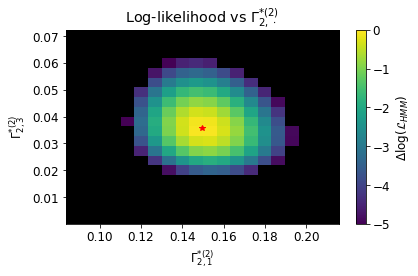

2
[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.0365 0.9635]]
-31.769862712062604

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.0564 0.9436]]
-21.629638407997845

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.0762 0.9238]]
-14.715874167872244

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.096  0.904 ]]
-9.83950945487959

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.1159 0.8841]]
-6.357250149703759

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.1357 0.8643]]
-3.881538361103594

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.1555 0.8445]]
-2.1604454930711654

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.1754 0.8246]]
-1.0216682636419137

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.1952 0.8048]]
-0.3430997617324465

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.2151 0.7849]]
-0.035815942763292696

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.     0.2

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0105 0.1952 0.7943]]
-1.5128052858963201

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0105 0.2151 0.7744]]
-1.2518466852998245

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0105 0.2349 0.7546]]
-1.2838212605238368

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0105 0.2547 0.7347]]
-1.5609712728510203

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0105 0.2746 0.7149]]
-2.0451187166654563

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0105 0.2944 0.6951]]
-2.7039255474082893

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0105 0.3142 0.6752]]
-3.5071966646646615

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0105 0.3341 0.6554]]
-4.42256949005241

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0105 0.3539 0.6356]]
-5.410703270801605

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0105 0.3738 0.6157]]
-6.422976790683606

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0105 0.3936 

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0211 0.3539 0.625 ]]
-6.666130702178634

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0211 0.3738 0.6052]]
-7.607752999814693

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0211 0.3936 0.5854]]
-8.508111243889289

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0211 0.4134 0.5655]]
-9.3571736531012

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0237 0.0365 0.9398]]
-30.233402363541245

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0237 0.0564 0.92  ]]
-21.5906150160954

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0237 0.0762 0.9001]]
-15.616356761012867

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0237 0.096  0.8803]]
-11.367162037757225

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0237 0.1159 0.8604]]
-8.317628213055286

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0237 0.1357 0.8406]]
-6.146368515936047

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0237 0.1555 0.8208

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0342 0.1159 0.8499]]
-9.378871301014442

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0342 0.1357 0.8301]]
-7.299122112432087

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0342 0.1555 0.8102]]
-5.860116196996387

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0342 0.1754 0.7904]]
-4.92410297673996

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0342 0.1952 0.7706]]
-4.392117893639806

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0342 0.2151 0.7507]]
-4.190780133230874

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0342 0.2349 0.7309]]
-4.263940603643277

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0342 0.2547 0.7111]]
-4.566871183065814

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0342 0.2746 0.6912]]
-5.061620636643056

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0342 0.2944 0.6714]]
-5.712552215249161

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0342 0.3142 0.6515]

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0447 0.2746 0.6807]]
-6.398640900046303

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0447 0.2944 0.6609]]
-7.034922900802485

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0447 0.3142 0.641 ]]
-7.771881300450332

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0447 0.3341 0.6212]]
-8.558929676437401

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0447 0.3539 0.6013]]
-9.345825142434478

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0447 0.3738 0.5815]]
-10.101331597281387

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0447 0.3936 0.5617]]
-10.826596219289058

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0447 0.4134 0.5418]]
-11.545767479128699

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0474 0.0365 0.9161]]
-30.545848380337702

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0474 0.0564 0.8963]]
-22.773810910573957

[[0.8861 0.1139 0.    ]
 [0.1496 0.8148 0.0356]
 [0.0474 0.0762 0

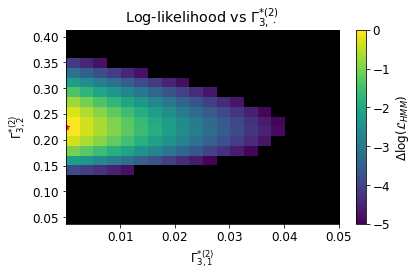

In [47]:
# fine-scale gamma

fine_scale_gamma_ls = {}

for state_num in range(pars.K[0]):
    print(state_num)
        
    for row in range(pars.K[1]):
        print(row)
                
        cols = np.delete([0,1,2],row)
        orig_eta = deepcopy(hhmm.eta[1][state_num])
        ls = np.zeros((n_points,n_points))
        
        orig_gamma = HHMM.eta_2_ptm(hhmm.eta[1][state_num])

        # get ranges to iterate through
        if np.isinf(hhmm.SEs['Gamma_fine'][state_num][row,cols[0]]):
            se = 0.01
        else:
            se = hhmm.SEs['Gamma_fine'][state_num][row,cols[0]]
            
            
        gamma_12s = np.linspace(max(10e-8,orig_gamma[row,cols[0]] - 5*se),
                                min(1.0-10e-8,orig_gamma[row,cols[0]] + 5*se),
                                n_points)
        
        if np.isinf(hhmm.SEs['Gamma_fine'][state_num][row,cols[1]]):
            se = 0.01
        else:
            se = hhmm.SEs['Gamma_fine'][state_num][row,cols[1]]

        gamma_13s = np.linspace(max(10e-8,orig_gamma[row,cols[1]] - 5*se),
                                min(1.0-10e-8,orig_gamma[row,cols[1]] + 5*se),
                                n_points)

        for i,gamma_12 in enumerate(gamma_12s):
            for j,gamma_13 in enumerate(gamma_13s):
        
                gamma_11 = 1.0-gamma_12-gamma_13
                
                if gamma_11 > 0.0:
                    hhmm.eta[1][state_num][row,cols[0]] = np.log(gamma_12) - np.log(gamma_11)
                    hhmm.eta[1][state_num][row,cols[1]] = np.log(gamma_13) - np.log(gamma_11)
                    ls[i,j] = hhmm.likelihood(data) - orig_l
                else:
                    ls[i,j] = -np.inf
                    
                print(HHMM.eta_2_ptm(hhmm.eta[1][state_num]))
                #print(HHMM.eta_2_ptm(orig_eta))
                print(ls[i,j])
                print('')

        hhmm.eta[1][state_num] = orig_eta
        
        fine_scale_gamma_ls[state_num] = ls

        # make a heatmap
        cmap = plt.cm.viridis
        cmap.set_under()
        plt.imshow(np.rot90(ls), vmin = -5, vmax = 0, cmap=cmap,
                   extent = [gamma_12s[0],gamma_12s[-1]] + [gamma_13s[0],gamma_13s[-1]], 
                   aspect='auto')
        gamma0 = HHMM.eta_2_ptm(hhmm.eta[1][state_num])
        plt.plot(gamma0[row,cols[0]],gamma0[row,cols[1]],'r*')
        c = plt.colorbar()
        c.set_label('$\Delta \log(\mathcal{L}_{HMM})$')
        plt.xlabel(r'$\Gamma^{*(%d)}_{%d,%d}$'%(state_num+1,row+1,cols[0]+1))
        plt.ylabel(r'$\Gamma^{*(%d)}_{%d,%d}$'%(state_num+1,row+1,cols[1]+1))
        plt.title(r'Log-likelihood vs $\Gamma^{*(%d)}_{%d,\cdot}$'%(state_num+1,row+1))
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_fine-gamma-likelihood-%d-row_%d.png' % (year,whale,s_dive,e_dive,model,state_num,row),dpi=500)
        plt.show()
        
        with open('fine_scale_gamma_ls', 'wb') as handle:
            pickle.dump(fine_scale_gamma_ls, handle)